# Imports

In [ ]:
###########################
# Imports and Setup
###########################
!python -m spacy download de_core_news_sm
!pip install datasets
from IPython.display import clear_output
clear_output()
print('spacy & datasets downloaded')


import os
import re
import time
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="viridis")

import torch
print("CUDA available:", torch.cuda.is_available())

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# NLP & Tokenization
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('de_core_news_sm')
from collections import Counter
from nltk.util import ngrams

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_curve, auc, f1_score)

# Transformers & Datasets
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from datasets import Dataset
import torch.nn as nn
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# SHAP & WordCloud & t-SNE
import shap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE



spacy & datasets downloaded
CUDA available: False
Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ChatGPT / LLM via LangChain
!pip install -U langchain-openai openai tiktoken
import asyncio
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
clear_output()
print('Installed LangChain')

Installed LangChain


In [ ]:
###########################
# Global Variables and Paths
###########################
DATABASE_PATH = Path("/content/drive/MyDrive/DeTox-Dataset_complete.sqlite3")
OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"

In [ ]:
###########################
# Data Loading
###########################
import sqlite3 as sqlite
database_path = Path("/content/drive/MyDrive/DeTox-Dataset_complete.sqlite3") # path to your database file
dbconnect = None
cursor = None

if not database_path.is_file():
    print(f"Database {database_path} does not exist. Creating a new database now ...")
try:
        # open database connection
        dbconnect = sqlite.connect(database_path, detect_types=sqlite.PARSE_DECLTYPES | sqlite.PARSE_COLNAMES)
        cursor = dbconnect.cursor()
        # Check Foreign-Key Constraints can be switched off if needed with the following line:
        # cursor.execute("PRAGMA foreign_keys = OFF;")
except sqlite.Error as e:
        # if errors occur
        print("Error %s:" % e.args[0])
annotations = pd.read_sql_query("SELECT * from Goldstandard;", con=dbconnect)
annotations.head(5)

,c_id,c_text,nb_annotators,dataset_id,duration,incomp,sentiment,hate_speech,criminal_rel,p_86,...,discrim_engagement,discrim_sexIdent,discrim_characteristics,discrim_nation,discrim_religion,discrim_socialStatus,discrim_worldview,discrim_Ethnicity,threat,extrem
0,1383933685519437827,@robinalexander_ @welt Greta wird sich bedanke...,4,6.0,366.750000,0.000000,-1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1383935384464236546,Noch #6Wochen liegen bis zu Lockerungen vor un...,4,6.0,149.000000,0.000000,-1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1383936217331363852,"Diese Form der Frage zeigt, dass der Altmaier ...",3,8.0,48.333333,0.000000,-1.0,0.333333,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1383940124530991113,@katzesuess Alter was hat ihm denn bitte so ha...,3,1.0,44.000000,0.000000,-1.0,0.666667,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1383946030975045641,Black Lives Matter Archive - Artist Krishnendu...,3,7.0,20.333333,0.333333,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Common Functions

In [ ]:
###########################
# Common Functions (Preprocessing, Cleaning, etc.)
###########################

# Preprocessing and lemmatization
def preprocess_and_lemmatize(text):
    """
    Convert text to lowercase, remove punctuation, and lemmatize the text using spaCy.
    Parameters:
      text (str): The raw input text.

    Returns:
      list: A list of lemmatized tokens.
    """
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_space and not token.like_num]

# Extended stopword set
def get_extended_stopwords():
    """
    Return an extended set of German stopwords.
    """
    german_stop = set(stopwords.words('german'))
    additional = {'wer', 'mehr', 'geht', 'gibt', 'mal', 'ja', 'immer', 'schon'}
    return german_stop.union(additional)

EXTENDED_STOPWORDS = get_extended_stopwords()

def save_figure(fig, file_path):
    fig.savefig(file_path)
    plt.close(fig)
    print(f"Figure saved to {file_path}")


def clean_text(text):
    """
    Clean and lemmatize text, remove extended stopwords, and return a cleaned string.

    Parameters:
      text (str): Raw input text.

    Returns:
      str: Cleaned text.
    """
    tokens = preprocess_and_lemmatize(text)
    tokens = [token for token in tokens if token not in EXTENDED_STOPWORDS]
    return " ".join(tokens)

def create_binary_label(df, threshold=0.33):
    """
    Create a binary label 'hate_speech_binary' from the continuous 'hate_speech' column.

    Parameters:
      df (DataFrame): DataFrame with 'hate_speech' column.
      threshold (float): Threshold to determine hate speech.

    Returns:
      DataFrame: Updated DataFrame with binary label.
    """
    df['hate_speech_binary'] = (df['hate_speech'] > threshold).astype(int)
    return df

def prepare_data(df):
    """
    Prepare text and labels for model training.

    Parameters:
      df (DataFrame): Original DataFrame.

    Returns:
      X (Series): Cleaned text.
      y (Series): Binary labels.
    """
    df = create_binary_label(df, threshold=0.33)
    df['clean_text'] = df['c_text'].apply(clean_text)
    return df['clean_text'], df['hate_speech_binary']

def tokenize_function(example, tokenizer):
    """
    Tokenize text from example using the provided tokenizer.

    Parameters:
      example (dict): Example with 'c_text'.
      tokenizer: HuggingFace tokenizer.

    Returns:
      dict: Tokenized output.
    """
    return tokenizer(example["c_text"], truncation=True)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Plot confusion matrix as a heatmap.

    Parameters:
      cm (ndarray): Confusion matrix.
      classes (list): Class names.
      title (str): Plot title.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# EDA functions

In [ ]:
print(annotations['sentiment'].unique())
print("values for sentiment"+"\n"+"-"*50 + "\n")
print(annotations['hate_speech'].unique())
print("values for hate_speech"+"\n"+"-"*50 + "\n")

# Unique value counts for column sentiment and hate_speech
print(annotations['sentiment'].value_counts())
print("-"*50 + "\n")
print(annotations['hate_speech'].value_counts())

[-1.          0.          1.         -0.33333333 -0.66666667 -0.75
  0.66666667 -0.5         0.33333333 -0.6         0.5        -0.25
 -0.8         0.75               nan  0.25        0.2        -0.4
 -0.2       ]
values for sentiment
--------------------------------------------------

[0.         0.33333333 0.66666667 1.         0.5        0.75
 0.25       0.4               nan 0.14285714 0.2       ]
values for hate_speech
--------------------------------------------------

sentiment
-1.000000    4288
 0.000000    2157
-0.666667    1422
-0.333333    1164
-0.500000     542
 0.333333     142
 1.000000     136
-0.750000      99
 0.666667      89
-0.250000      68
 0.500000      43
 0.250000      10
 0.750000       9
-0.800000       4
-0.600000       1
 0.200000       1
-0.400000       1
-0.200000       1
Name: count, dtype: int64
--------------------------------------------------

hate_speech
0.000000    7290
0.333333    1318
0.666667     546
1.000000     545
0.500000     361
0.250000   

In [ ]:
###########################
# EDA Functions
###########################
def plot_word_and_char_counts(df):
    """
    Plot distributions for word count and character count.
    """
    df['word_count'] = df['c_text'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['c_text'].apply(lambda x: len(str(x)))

    plt.figure(figsize=(8,6))
    ax1 = sns.histplot(df, x='word_count', bins=30, color=sns.color_palette("viridis", n_colors=1)[0])
    plt.title('Word Count Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    for patch in ax1.patches:
        x = patch.get_x() + patch.get_width()/2.
        y = patch.get_height()
        if y > 0:
            ax1.text(x, y+5, f'{int(y)}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,6))
    ax2 = sns.histplot(df, x='char_count', bins=30, color=sns.color_palette("viridis", n_colors=2)[0])
    plt.title('Character Count Distribution')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    for patch in ax2.patches:
        x = patch.get_x() + patch.get_width()/2.
        y = patch.get_height()
        if y > 0:
            ax2.text(x, y+5, f'{int(y)}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_top_words_and_bigrams(df):
    """
    Plot top words (with/without stopwords) and top bigrams.
    """
    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text

    all_words = []
    for comment in df['c_text']:
        tokens = preprocess_text(comment).split()
        all_words.extend(tokens)

    word_counts_all = Counter(all_words)
    german_stop = set(stopwords.words('german'))
    all_words_no_stop = [word for word in all_words if word not in german_stop]
    word_counts_no_stop = Counter(all_words_no_stop)

    top20_all = word_counts_all.most_common(20)
    top20_no_stop = word_counts_no_stop.most_common(20)

    def plot_top_words(top_words, title):
        plot_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
        plt.figure(figsize=(10,6))
        ax = sns.barplot(data=plot_df, x='Count', y='Word', palette="viridis")
        plt.title(title)
        plt.xlabel('Count')
        plt.ylabel('Word')
        for p in ax.patches:
            width = p.get_width()
            ax.text(width+1, p.get_y()+p.get_height()/2., f'{int(width)}', ha='left', va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

    plot_top_words(top20_all, "Top 20 Most Used Words (Including Stopwords)")
    plot_top_words(top20_no_stop, "Top 20 Most Used Words (Excluding German Stopwords)")

    # Bigram extraction with lemmatization.
    all_tokens = []
    for comment in df['c_text']:
        tokens = preprocess_and_lemmatize(comment)
        all_tokens.extend(tokens)
    extended_stop = get_extended_stopwords()
    tokens_filtered = [token for token in all_tokens if token not in extended_stop]

    all_bigrams = []
    for comment in df['c_text']:
        tokens = preprocess_and_lemmatize(comment)
        tokens = [token for token in tokens if token not in extended_stop]
        if len(tokens) >= 2:
            bigrams_in_comment = list(ngrams(tokens, 2))
            all_bigrams.extend(bigrams_in_comment)
    bigram_freq = Counter(all_bigrams)
    top20_bigrams = bigram_freq.most_common(20)

    def plot_top_bigrams(top_bigrams, title):
        plot_df = pd.DataFrame([(f"{w1} {w2}", count) for ((w1, w2), count) in top_bigrams],
                               columns=['Bigram', 'Count'])
        plt.figure(figsize=(10,6))
        ax = sns.barplot(data=plot_df, x='Count', y='Bigram', palette="viridis")
        plt.title(title)
        plt.xlabel('Count')
        plt.ylabel('Bigram')
        for p in ax.patches:
            width = p.get_width()
            ax.text(width+1, p.get_y()+p.get_height()/2., f'{int(width)}', ha='left', va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

    plot_top_bigrams(top20_bigrams, "Top 20 Most Common 2-grams (Excluding Extended Stopwords)")

def plot_wordcloud(df):
    """
    Generate and display a word cloud from the cleaned text.
    """
    all_tokens_filtered = []
    for comment in df['c_text']:
        tokens = preprocess_and_lemmatize(comment)
        filtered = [token for token in tokens if token not in EXTENDED_STOPWORDS]
        all_tokens_filtered.extend(filtered)
    text_wc = " ".join(all_tokens_filtered)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text_wc)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Comments (Excluding Extended Stopwords)", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_tsne_embeddings(df, top_n=100):
    """
    Train a Word2Vec model on the corpus and plot a t-SNE visualization of the top N word embeddings.
    """
    corpus = []
    for comment in df['c_text']:
        tokens = preprocess_and_lemmatize(comment)
        tokens = [token for token in tokens if token not in EXTENDED_STOPWORDS]
        if tokens:
            corpus.append(tokens)
    print("Sample tokenized comment:", corpus[0])
    from gensim.models import Word2Vec
    w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, seed=42)
    all_tokens = [token for sentence in corpus for token in sentence]
    token_freq = Counter(all_tokens)
    top_words = [word for word, count in token_freq.most_common(top_n) if word in w2v_model.wv]
    word_vectors = [w2v_model.wv[word] for word in top_words]
    word_vectors_np = np.array(word_vectors)
    tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
    tsne_result = tsne.fit_transform(word_vectors_np)
    tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
    tsne_df['Word'] = top_words
    plt.figure(figsize=(12,8))
    ax = sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', s=100, color=sns.color_palette("viridis", 1)[0])
    plt.title("t-SNE Visualization of Top 100 Word Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    for i, row in tsne_df.iterrows():
        ax.text(row['Dim1']+0.3, row['Dim2']+0.3, row['Word'], fontsize=9)
    plt.tight_layout()
    plt.show()

# Model Training Functions

## TF-IDF

In [ ]:
def train_tf_idf_xgb(df,
                     output_path="/content/drive/MyDrive/NEW_TM_results/aggregated_tfidf_results.csv",
                     cm_path="/content/drive/MyDrive/NEW_TM_results/tfidf_confusion_matrix.png"):
    """
    Train a TF-IDF + XGBoost model for hate speech detection, ensuring the same validation split as transformers.

    Parameters:
      df (DataFrame): The original DataFrame with at least 'c_text' and 'hate_speech'.

    Steps:
      1) Apply the same threshold (0.33) and cleaning as transformers.
      2) Use the exact same split (test_size=0.2, random_state=42, stratify=df["hate_speech_binary"]).
      3) Train on train_df, evaluate on val_df, then save aggregator results with 'c_text', 'hate_speech_binary', 'pred_tfidf'.
    """

    if not isinstance(df, pd.DataFrame):
        raise ValueError("The input 'df' must be a DataFrame. Do not pass the tuple returned by prepare_data().")

    df = create_binary_label(df, threshold=0.33)
    df['clean_text'] = df['c_text'].apply(clean_text)

    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df["hate_speech_binary"]
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    X_train = train_df["clean_text"]
    y_train = train_df["hate_speech_binary"]
    X_val = val_df["clean_text"]
    y_val = val_df["hate_speech_binary"]

    # Train TF-IDF + XGBoost on the training set
    vectorizer = TfidfVectorizer(max_features=10000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)

    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_tfidf, y_train)
    y_pred = xgb_clf.predict(X_val_tfidf)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    print("TF-IDF + XGBoost Evaluation (Consistent Split):")
    print("Accuracy:", round(acc, 4), "F1 Score:", round(f1, 4))
    print(report)

    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=["Non-Hate Speech", "Hate Speech"],
                yticklabels=["Non-Hate Speech", "Hate Speech"],
                ax=ax)
    ax.set_title("TF-IDF + XGBoost Confusion Matrix (Consistent Split)")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    plt.tight_layout()
    save_figure(fig, cm_path)

    val_df = val_df.reset_index(drop=True)
    val_df["pred_tfidf"] = y_pred
    val_df[["c_text", "hate_speech_binary", "pred_tfidf"]].to_csv(output_path, index=False)
    print("Aggregated TF-IDF results saved to", output_path)

    # Return metrics
    eval_metrics = {"eval_accuracy": acc, "eval_f1": f1, "eval_precision": None, "eval_recall": None}
    return eval_metrics, y_pred, vectorizer

## Transformer Model

In [ ]:
from transformers import EarlyStoppingCallback
def train_transformer_model(model_name, num_epochs=2, batch_size=16, subfolder="trans_mod1", df=None, output_base_dir="/content/drive/MyDrive/NEW_TM_results/"):
    """
    Fine-tune a HuggingFace transformer model for binary classification.
    Saves checkpoints and logs to a subfolder under OUTPUT_DIR.

    Updates:
      - Early stopping added (patience=1)
      - Increased weight decay to 0.05
      - Default epochs set to 2
      - remove_unused_columns set to False to avoid column mismatch issues.
    """
    output_dir = os.path.join(output_base_dir, subfolder)
    log_dir = os.path.join(output_dir, "logs")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    df = create_binary_label(df, threshold=0.33)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["hate_speech_binary"])
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
    model.classifier = nn.Linear(model.config.hidden_size, 2)
    if torch.cuda.is_available():
        model.to("cuda")

    def tokenize_fn(example):
        return tokenizer(example["c_text"], truncation=True)

    train_dataset = train_dataset.map(tokenize_fn, batched=True)
    val_dataset = val_dataset.map(tokenize_fn, batched=True)
    train_dataset = train_dataset.rename_column("hate_speech_binary", "labels")
    val_dataset = val_dataset.rename_column("hate_speech_binary", "labels")
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
        return {"eval_accuracy": acc, "eval_precision": precision, "eval_recall": recall, "eval_f1": f1}

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.05,
        logging_dir=log_dir,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        save_total_limit=3,
        remove_unused_columns=False,
    )

    from transformers import EarlyStoppingCallback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print("Evaluation results for", model_name, "saved in", output_dir, ":", eval_results)

    # Save evaluation metrics.
    eval_metrics_file = os.path.join(output_dir, "eval_metrics.csv")
    pd.DataFrame([eval_results]).to_csv(eval_metrics_file, index=False)
    print("Transformer evaluation metrics saved to", eval_metrics_file)

    # Plot and save confusion matrix.
    preds = trainer.predict(val_dataset).predictions.argmax(axis=-1)
    true_labels = trainer.predict(val_dataset).label_ids
    cm = confusion_matrix(true_labels, preds)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=["Non-Hate Speech", "Hate Speech"],
                yticklabels=["Non-Hate Speech", "Hate Speech"],
                ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.tight_layout()
    cm_file = os.path.join(output_dir, "confusion_matrix.png")
    fig.savefig(cm_file)
    plt.close(fig)
    print("Confusion matrix saved to", cm_file)

    return eval_results, trainer


## ChatGPT model

In [ ]:
from tqdm.notebook import tqdm
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
try:
    from openai.error import RateLimitError
except ModuleNotFoundError:
    print("openai.error module not found; using a generic Exception as fallback for rate limits.")
    RateLimitError = Exception

# Insert your ChatGPT API key below.
OPENAI_API_TOKEN = ""  # <-- Replace with your actual API key.
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

# Define prompt templates in German.
system_template = (
    "Du bist ein Experte für die Analyse von Hassrede in deutschen Texten. "
    "Bitte klassifiziere den folgenden Kommentar als Hassrede oder nicht. "
    "Gib als Antwort nur '1' aus, wenn der Kommentar Hassrede enthält, und '0', wenn nicht."
)
human_template = "{dialogue}"
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_template),
    ("human", human_template),
])

# Initialize the ChatOpenAI model.
llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")

# Global dictionary to track attempts per tweet.
attempts_dict = {}

async def classify_comment_async(comment, idx, semaphore, max_retries=3):
    """
    Asynchronously classify a single comment using ChatGPT.
    Uses a semaphore to limit concurrency and retries on rate-limit errors.
    Tracks attempts per tweet (using its DataFrame index).
    """
    async with semaphore:
        prompt_messages = chat_prompt.format_messages(dialogue=comment)
        retries = attempts_dict.get(idx, 0)
        while retries < max_retries:
            try:
                result = await asyncio.to_thread(llm.invoke, prompt_messages)
                return result.content.strip()
            except Exception as e:
                if isinstance(e, RateLimitError) or ("requests per day" in str(e)):
                    retries += 1
                    attempts_dict[idx] = retries
                    # If the error message indicates a daily limit, break immediately.
                    if "requests per day" in str(e):
                        return None
                    await asyncio.sleep(9)
                else:
                    return None
        # If max retries exceeded, return None.
        return None

async def run_chatgpt_classification_async(df, concurrency=8):
    """
    Asynchronously classify all comments in a DataFrame using ChatGPT in batches.
    Uses a tqdm progress bar and saves results to a checkpoint file.

    Parameters:
      df (DataFrame): DataFrame with a column 'c_text'.
      concurrency (int): Maximum number of concurrent requests.

    Returns:
      DataFrame: Updated DataFrame with a new column 'chatgpt_class'.
    """
    semaphore = asyncio.Semaphore(concurrency)
    results_list = []
    # Process in batches to enable checkpointing
    batch_size = 250
    processed_df = pd.DataFrame(columns=df.columns)

    for start in range(0, len(df), batch_size):
        batch = df.iloc[start:start+batch_size]
        tasks = []
        for idx, row in batch.iterrows():
            tasks.append(asyncio.create_task(classify_comment_async(row["c_text"], idx, semaphore)))
        # Use return_exceptions=True so that one failing task doesn't cancel others.
        batch_results = await asyncio.gather(*tasks, return_exceptions=True)
        # Process results: if any element is an Exception, set it to None.
        batch_results = [res if not isinstance(res, Exception) else None for res in batch_results]
        batch = batch.copy()
        batch["chatgpt_class"] = batch_results

        processed_df = pd.concat([processed_df, batch])
        # Save checkpoint after each batch.
        checkpoint_file = os.path.join("/content/drive/MyDrive/NEW_TM_results/", "chatgpt_results.csv")
        processed_df.to_csv(checkpoint_file, index=False)
        print(f"Checkpoint saved: {len(processed_df)} rows processed so far.")

        # Check if any of the batch results is None due to daily limit error.
        if any(res is None for res in batch_results):
            print("Some requests failed due to daily limits. Stopping further processing for now.")
            break
    return processed_df

openai.error module not found; using a generic Exception as fallback for rate limits.


# Evaluation Functions

In [ ]:
###########################
# Error Analysis Function
###########################
def perform_error_analysis(results_df, model_pred_cols, true_col="hate_speech_binary", save_path=None):
    """
    Compute and plot error counts across models, then print a summary table.
    """
    def count_errors(row):
        errors = 0
        for col in model_pred_cols:
            if row[col] != row[true_col]:
                errors += 1
        return errors
    results_df["error_count"] = results_df.apply(count_errors, axis=1)

    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(results_df["error_count"], bins=range(0, len(model_pred_cols)+2), discrete=True, color="mediumpurple", ax=ax)
    ax.set_title("Distribution of Misclassification Count Across Models")
    ax.set_xlabel("Number of Models Misclassifying a Comment")
    ax.set_ylabel("Number of Comments")
    ax.set_xticks(range(0, len(model_pred_cols)+1))
    plt.tight_layout()
    if save_path:
        save_figure(fig, save_path)
    else:
        plt.show()

    error_summary = results_df["error_count"].value_counts().sort_index().reset_index()
    error_summary.columns = ["Num_Misclassifications", "Count"]
    print("Error Summary Table (Across Models):")
    print(error_summary)

    all_wrong = results_df[results_df["error_count"] == len(model_pred_cols)]
    print("\nComments misclassified by all models (first 10):")
    print(all_wrong[["c_text", true_col] + model_pred_cols].head(10))

    return results_df


###########################
# Model Comparison Aggregation
###########################
def aggregate_model_results(results_list, model_names, save_path=None):
    """
    Aggregate evaluation metrics from different models into a DataFrame.
    """
    comparison_data = {
        "Model": model_names,
        "Accuracy": [res.get("eval_accuracy", None) for res in results_list],
        "Precision": [res.get("eval_precision", None) for res in results_list],
        "Recall": [res.get("eval_recall", None) for res in results_list],
        "F1 Score": [res.get("eval_f1", None) for res in results_list]
    }
    agg_df = pd.DataFrame(comparison_data)
    if save_path:
        agg_df.to_csv(save_path, index=False)
        print("Aggregated evaluation metrics saved to", save_path)
    return agg_df


# EXECUTION

## EDA

=== Running CPU-based Pipeline ===


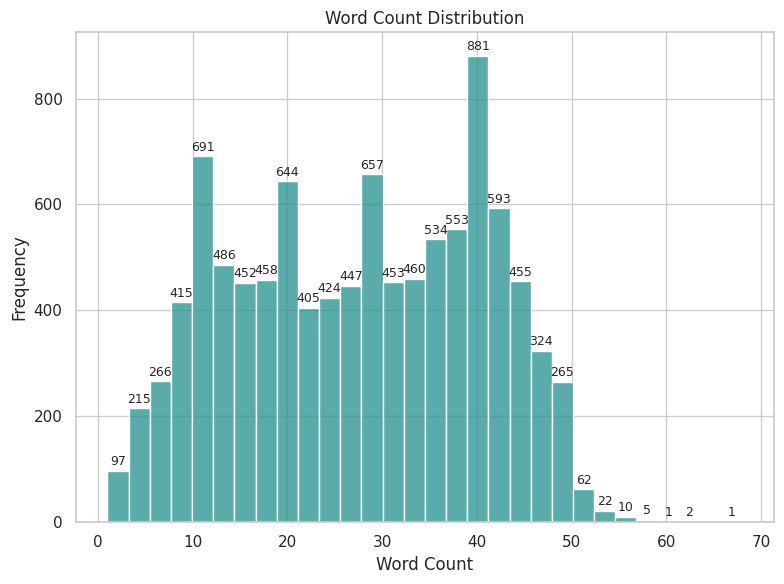

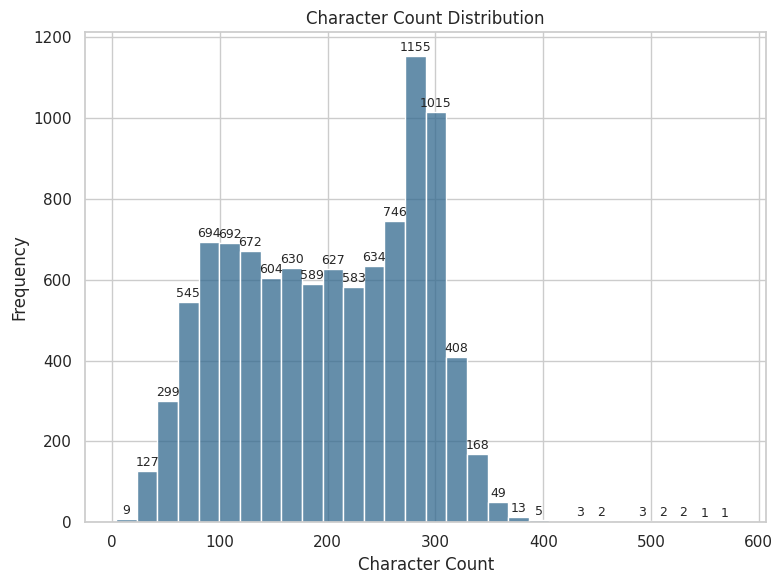

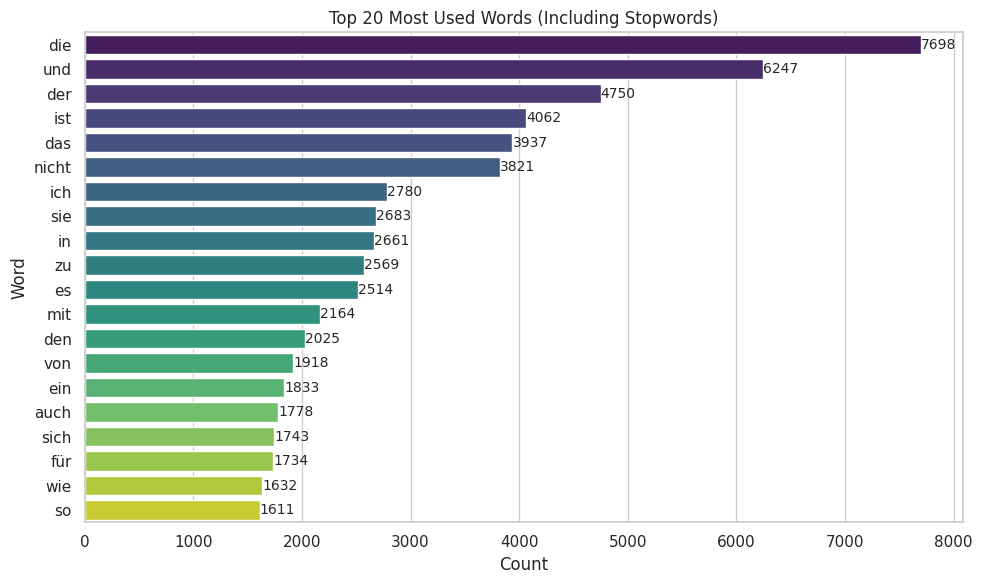

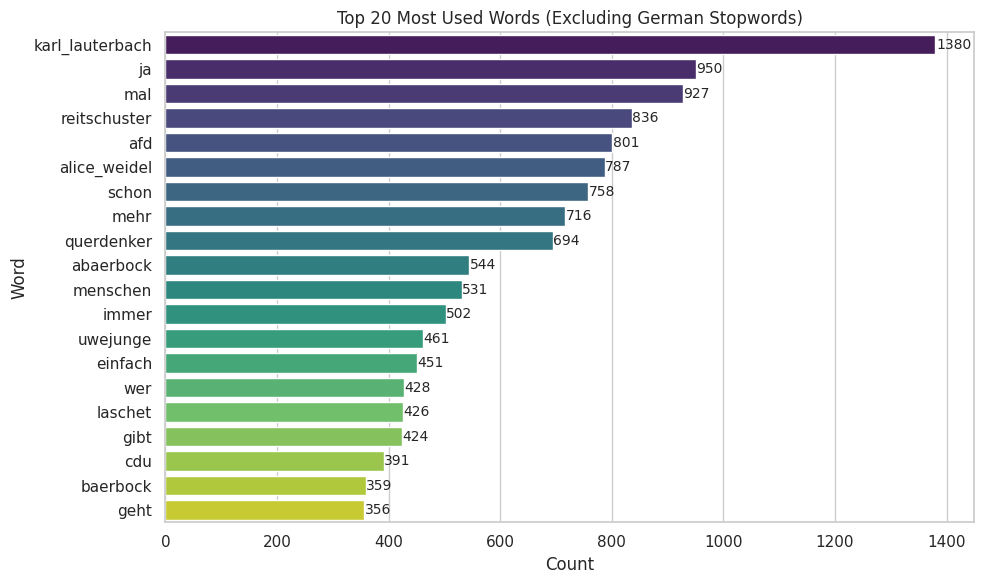

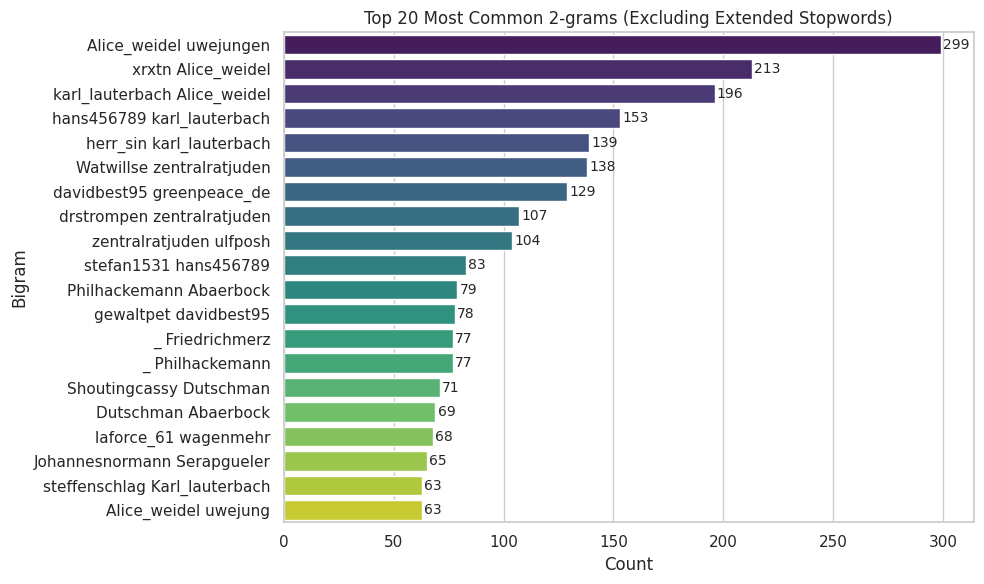

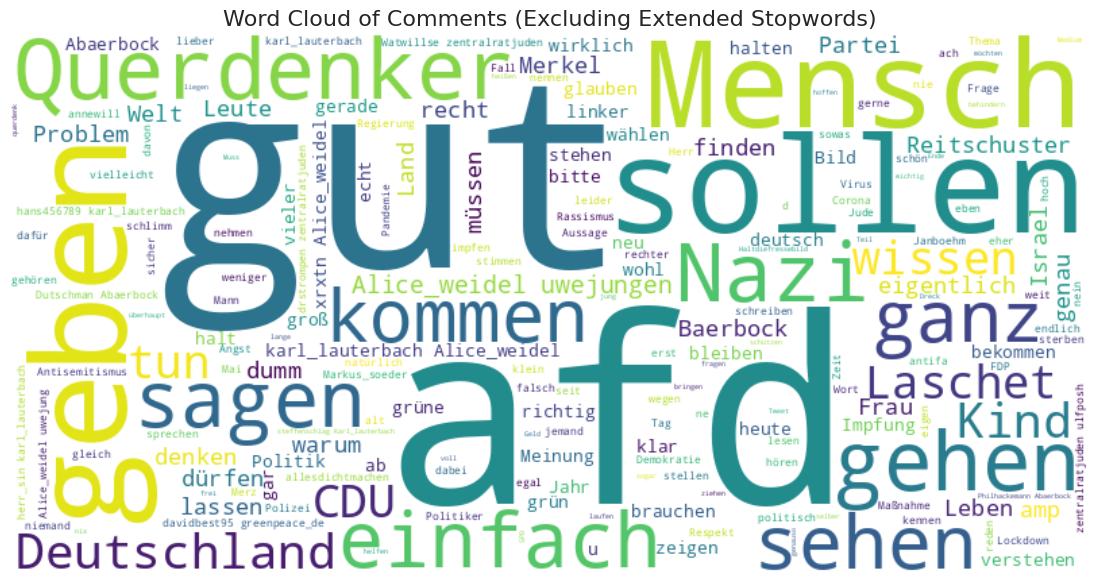

Sample tokenized comment: ['Robinalexander', '_', 'Welt', 'Greta', 'bedanken', 'söde', 'Reist', 'Privatjet', 'Nürnberg', 'Ergebnis', 'ab', 'Hause', 'sollen', 'einfach', 'abdanken', 'söder', 'vernünftig', 'denkender', 'Mensch']


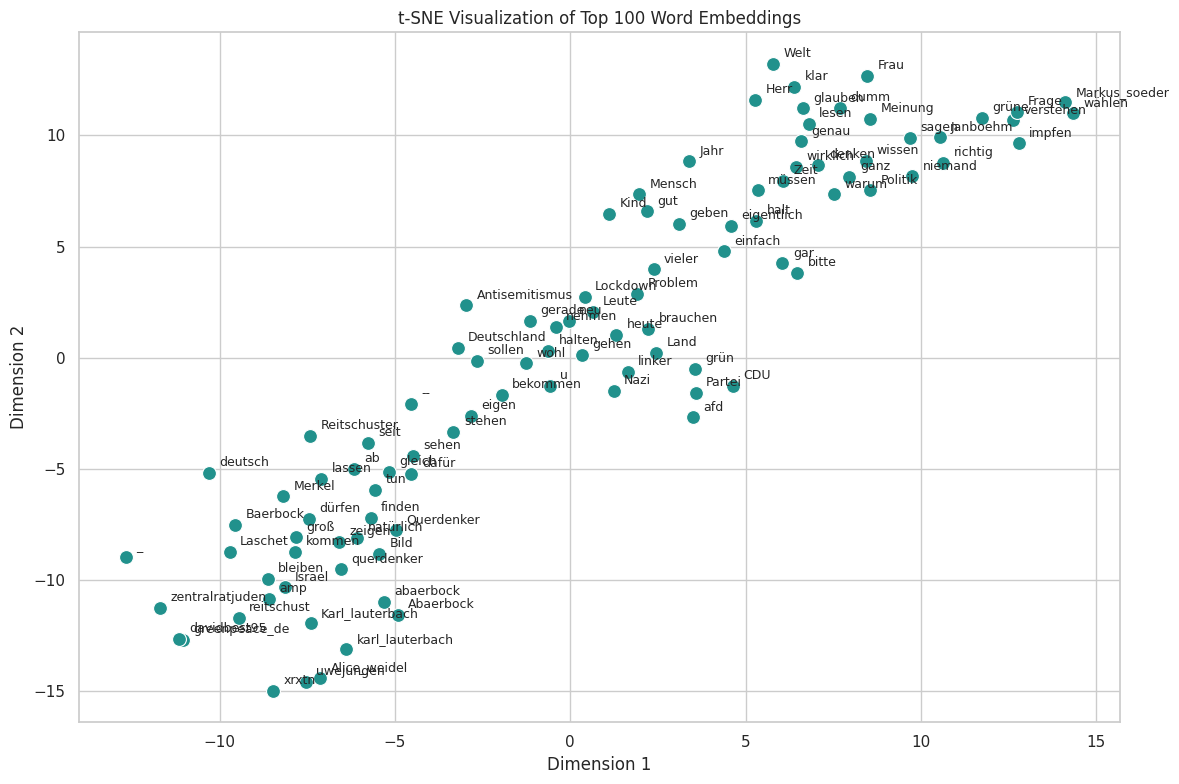

In [ ]:
# ----- CPU-Based Models Execution -----

print("=== Running CPU-based Pipeline ===")
plot_word_and_char_counts(annotations)
plot_top_words_and_bigrams(annotations)
plot_wordcloud(annotations)
plot_tsne_embeddings(annotations, top_n=100)

## CPU based models

In [ ]:
print("Training TF-IDF + XGBoost model (CPU) with the same split as transformers...")
eval_metrics_xgb, xgb_preds, vectorizer = train_tf_idf_xgb(
    annotations,
    output_path="/content/drive/MyDrive/NEW_TM_results/aggregated_tfidf_results.csv",
    cm_path="/content/drive/MyDrive/NEW_TM_results/tfidf_confusion_matrix.png"
)

Training TF-IDF + XGBoost model (CPU) with the same split as transformers...
TF-IDF + XGBoost Evaluation (Consistent Split):
Accuracy: 0.7617 F1 Score: 0.4053
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1496
           1       0.63      0.30      0.41       560

    accuracy                           0.76      2056
   macro avg       0.71      0.62      0.63      2056
weighted avg       0.74      0.76      0.73      2056

Figure saved to /content/drive/MyDrive/NEW_TM_results/tfidf_confusion_matrix.png
Aggregated TF-IDF results saved to /content/drive/MyDrive/NEW_TM_results/aggregated_tfidf_results.csv


In [ ]:
# Model 3: ChatGPT Classification (CPU)
# Load checkpoint if it exists.
checkpoint_file = os.path.join("/content/drive/MyDrive/NEW_TM_results/", "chatgpt_results.csv")
if os.path.exists(checkpoint_file):
    print("Loading existing ChatGPT checkpoint...")
    checkpoint_df = pd.read_csv(checkpoint_file)
    # Ensure the checkpoint has the 'chatgpt_class' column.
    if "chatgpt_class" not in checkpoint_df.columns:
        checkpoint_df["chatgpt_class"] = ""
    annotations = pd.merge(annotations, checkpoint_df[["c_text", "chatgpt_class"]],
                           on="c_text", how="left", suffixes=("", "_chk"))
    annotations["chatgpt_class"] = annotations.apply(
        lambda row: row["chatgpt_class"] if pd.notnull(row["chatgpt_class"]) and row["chatgpt_class"] != ""
                   else row.get("chatgpt_class_chk", ""), axis=1)
    annotations.drop(columns=["chatgpt_class_chk"], inplace=True)
else:
    print("No ChatGPT checkpoint found; initializing 'chatgpt_class' as empty.")
    annotations["chatgpt_class"] = ""


# Now, check for unprocessed rows.
if "chatgpt_class" not in annotations.columns:
    print("Error: 'chatgpt_class' column still missing!")
else:
    unprocessed = annotations[(annotations["chatgpt_class"].isnull()) | (annotations["chatgpt_class"] == "")]
    print(f"Found {len(unprocessed)} unprocessed comments out of {len(annotations)} total.")

# Identify unprocessed rows.
unprocessed = annotations[(annotations["chatgpt_class"].isnull()) | (annotations["chatgpt_class"] == "")]
print(f"Found {len(unprocessed)} unprocessed comments out of {len(annotations)} total.")

# Process unprocessed rows in batches.
async def run_chatgpt_in_batches(df, concurrency=8, batch_size=250):
    processed_df = pd.DataFrame(columns=df.columns)
    for start in range(0, len(df), batch_size):
        batch = df.iloc[start:start+batch_size]
        print(f"Processing batch: rows {start} to {start+batch_size}...")
        batch_results = await run_chatgpt_classification_async(batch, concurrency=concurrency)
        processed_df = pd.concat([processed_df, batch_results])
        checkpoint_file = os.path.join("/content/drive/MyDrive/NEW_TM_results/", "chatgpt_results.csv")
        processed_df.to_csv(checkpoint_file)
        print(f"Checkpoint saved: {len(processed_df)} rows processed so far.")
    return processed_df

# Run the batch processing (use top-level await in a cell)
processed_chat_results = await run_chatgpt_in_batches(unprocessed, concurrency=8, batch_size=250)
annotations.update(processed_chat_results)
annotations.to_csv(checkpoint_file, index=False)
print(f"Final ChatGPT checkpoint saved to {checkpoint_file}.")
print(annotations[["c_text", "chatgpt_class"]].head())

Loading existing ChatGPT checkpoint...
Found 2355 unprocessed comments out of 10284 total.
Found 2355 unprocessed comments out of 10284 total.
Processing batch: rows 0 to 250...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 250 rows processed so far.
Processing batch: rows 250 to 500...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 500 rows processed so far.
Processing batch: rows 500 to 750...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 750 rows processed so far.
Processing batch: rows 750 to 1000...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 1000 rows processed so far.
Processing batch: rows 1000 to 1250...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 1250 rows processed so far.
Processing batch: rows 1250 to 1500...
Checkpoint saved: 250 rows processed so far.
Checkpoint saved: 1500 rows processed so far.
Processing batch: rows 1500 to 1750...
Checkpoint saved: 250 rows processed so far.
Check

In [ ]:
chatgpt_output = pd.read_csv('/content/drive/MyDrive/NEW_TM_results/chatgpt_results.csv')
print(chatgpt_output.head(5))
chatgpt_output['chatgpt_class'].describe()

                  c_id                                             c_text  \
0  1383933685519437827  @robinalexander_ @welt Greta wird sich bedanke...   
1  1383935384464236546  Noch #6Wochen liegen bis zu Lockerungen vor un...   
2  1383936217331363852  Diese Form der Frage zeigt, dass der Altmaier ...   
3  1383940124530991113  @katzesuess Alter was hat ihm denn bitte so ha...   
4  1383946030975045641  Black Lives Matter Archive - Artist Krishnendu...   

   nb_annotators  dataset_id    duration    incomp  sentiment  hate_speech  \
0              4         6.0  366.750000  0.000000       -1.0     0.000000   
1              4         6.0  149.000000  0.000000       -1.0     0.000000   
2              3         8.0   48.333333  0.000000       -1.0     0.333333   
3              3         1.0   44.000000  0.000000       -1.0     0.666667   
4              3         7.0   20.333333  0.333333        0.0     0.000000   

   criminal_rel  p_86  ...  discrim_nation  discrim_religion  \
0   

,chatgpt_class
count,10284.000000
mean,0.515850
std,0.499773
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
def estimate_tokens(text):
    """
    Estimate the number of tokens in text by splitting on whitespace.
    (This is a rough estimate; for GPT models, using tiktoken would be more precise.)
    """
    return len(text.split())

annotations['token_count'] = annotations['c_text'].apply(estimate_tokens)

# Compute overall statistics:
total_tokens = annotations['token_count'].sum()
avg_tokens = annotations['token_count'].mean()
num_comments = len(annotations)

# Price per 1K tokens for GPT-3.5-turbo (gpt-3.5-turbo-1106)
price_per_1k_tokens = 0.002
estimated_cost = (total_tokens / 1000) * price_per_1k_tokens

cost_table = pd.DataFrame({
    'Metric': ['Total Comments', 'Total Tokens', 'Average Tokens per Comment', 'Price per 1K Tokens ($)', 'Estimated Cost ($)'],
    'Value': [num_comments, total_tokens, round(avg_tokens, 2), price_per_1k_tokens, round(estimated_cost, 4)]
})
print(cost_table)

                       Metric        Value
0              Total Comments   10284.0000
1                Total Tokens  282396.0000
2  Average Tokens per Comment      27.4600
3     Price per 1K Tokens ($)       0.0020
4          Estimated Cost ($)       0.5648


## GPU based models

In [ ]:
# ----- GPU-Based Models Execution -----
# Model 1: Transformer
print("Training Transformer Model 1 (GPU): oliverguhr/german-sentiment-bert")
eval_results_model1, trainer_model1 = train_transformer_model(
    model_name="oliverguhr/german-sentiment-bert",
    num_epochs=2, batch_size=16,
    subfolder="trans_mod1", df=annotations,
    output_base_dir=OUTPUT_DIR
)

Training Transformer Model 1 (GPU): oliverguhr/german-sentiment-bert


tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at oliverguhr/german-sentiment-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: silvio-klenk (silvio-klenk-pforzheim-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471500,0.484442,0.765078,0.695431,0.244643,0.361955
2,0.423100,0.475577,0.782588,0.642317,0.455357,0.532915


Evaluation results for oliverguhr/german-sentiment-bert saved in /content/drive/MyDrive/NEW_TM_results/trans_mod1 : {'eval_accuracy': 0.7825875486381323, 'eval_precision': 0.6423173803526449, 'eval_recall': 0.45535714285714285, 'eval_f1': 0.5329153605015674, 'eval_loss': 0.4755767285823822, 'eval_runtime': 12.8236, 'eval_samples_per_second': 160.329, 'eval_steps_per_second': 10.06, 'epoch': 2.0}
Transformer evaluation metrics saved to /content/drive/MyDrive/NEW_TM_results/trans_mod1/eval_metrics.csv


Confusion matrix saved to /content/drive/MyDrive/NEW_TM_results/trans_mod1/confusion_matrix.png


In [ ]:
# Model 2: Transformer
print("Training Transformer Model 2 (GPU): bert-base-german-cased")
eval_results_model2, trainer_model2 = train_transformer_model(
    model_name="bert-base-german-cased",
    num_epochs=2, batch_size=16,
    subfolder="trans_mod2", df=annotations,
    output_base_dir=OUTPUT_DIR
)

Training Transformer Model 2 (GPU): bert-base-german-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.415300,0.410288,0.813716,0.738544,0.489286,0.588614
2,0.277200,0.445800,0.816634,0.696774,0.578571,0.632195


Evaluation results for bert-base-german-cased saved in /content/drive/MyDrive/NEW_TM_results/trans_mod2 : {'eval_accuracy': 0.8166342412451362, 'eval_precision': 0.6967741935483871, 'eval_recall': 0.5785714285714286, 'eval_f1': 0.6321951219512195, 'eval_loss': 0.44579967856407166, 'eval_runtime': 12.8576, 'eval_samples_per_second': 159.905, 'eval_steps_per_second': 10.033, 'epoch': 2.0}
Transformer evaluation metrics saved to /content/drive/MyDrive/NEW_TM_results/trans_mod2/eval_metrics.csv


Confusion matrix saved to /content/drive/MyDrive/NEW_TM_results/trans_mod2/confusion_matrix.png


In [ ]:
import json

log_history_1 = trainer_model1.state.log_history
model1_log_file = os.path.join("/content/drive/MyDrive/NEW_TM_results/", "trans_mod1_log_history.json")
with open(model1_log_file, "w") as f:
    json.dump(log_history_1, f)
print(f"Model 1 log history saved to {model1_log_file}")


log_history_2 = trainer_model2.state.log_history
model2_log_file = os.path.join("/content/drive/MyDrive/NEW_TM_results/", "trans_mod2_log_history.json")
with open(model2_log_file, "w") as f:
    json.dump(log_history_2, f)
print(f"Model 2 log history saved to {model2_log_file}")


Model 1 log history saved to /content/drive/MyDrive/NEW_TM_results/trans_mod1_log_history.json
Model 2 log history saved to /content/drive/MyDrive/NEW_TM_results/trans_mod2_log_history.json


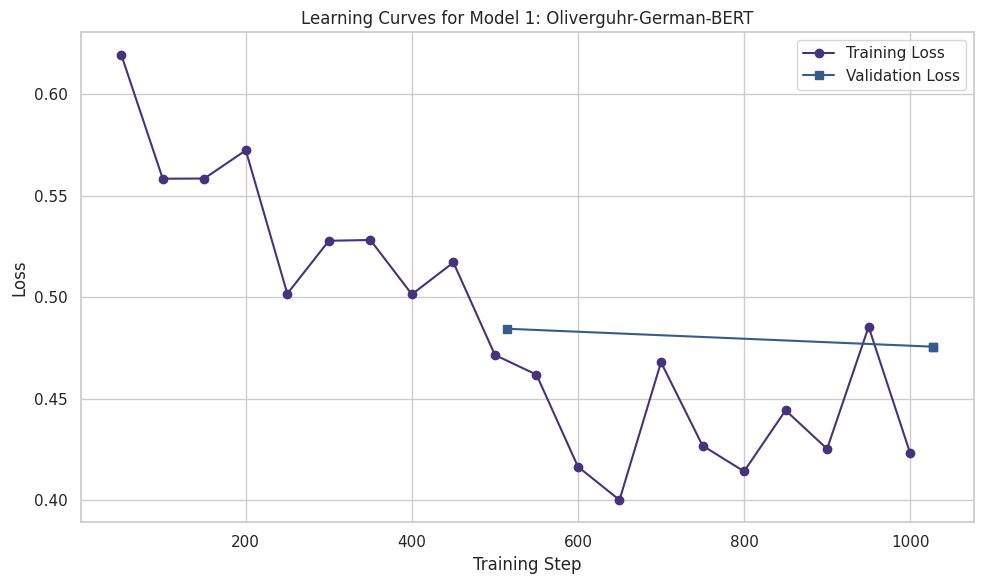

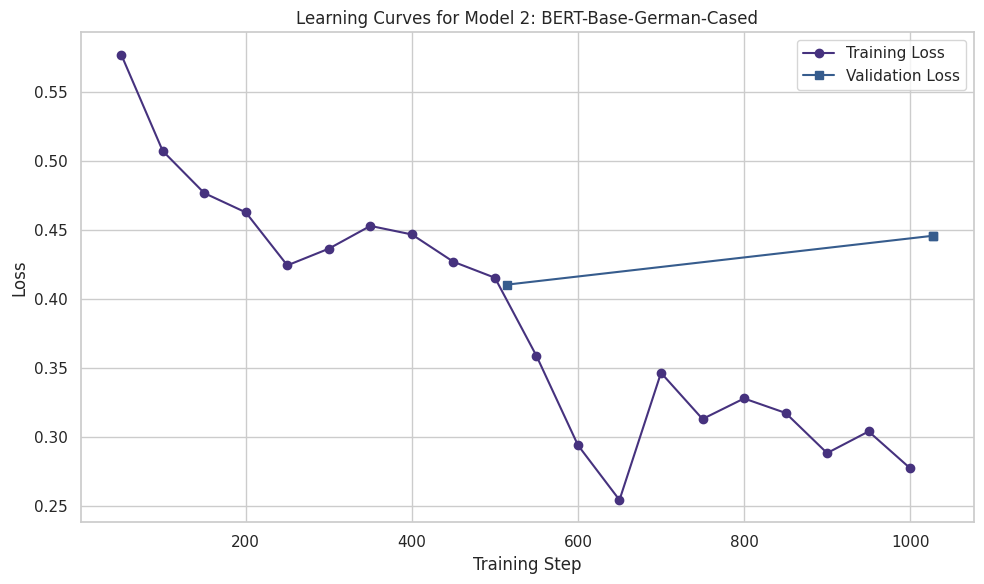

In [ ]:
def plot_learning_curves(trainer, model_name="Transformer"):
    train_loss_steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []

    for entry in trainer.state.log_history:
        if "loss" in entry and "eval_loss" not in entry:
            train_loss_steps.append(entry["step"])
            train_losses.append(entry["loss"])
        if "eval_loss" in entry:
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_steps, train_losses, label="Training Loss", marker="o")
    plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="s")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title(f"Learning Curves for {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(trainer_model1, model_name="Model 1: Oliverguhr-German-BERT")
plot_learning_curves(trainer_model2, model_name="Model 2: BERT-Base-German-Cased")


Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

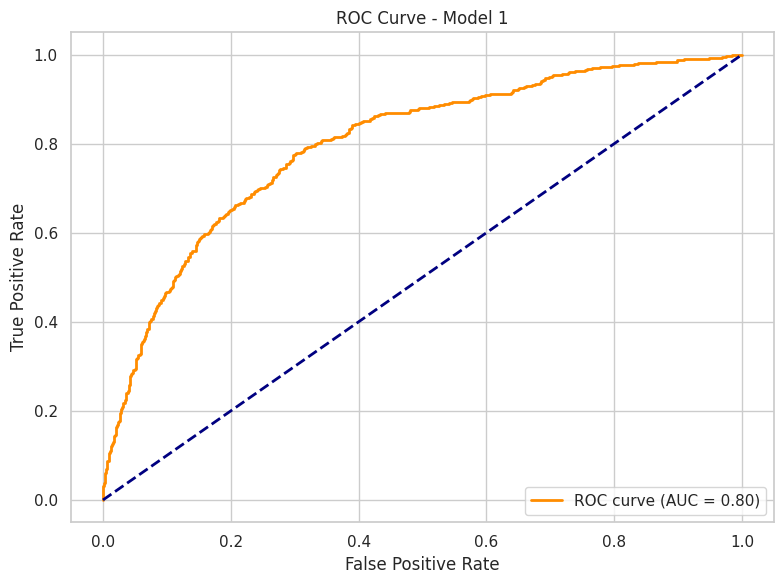

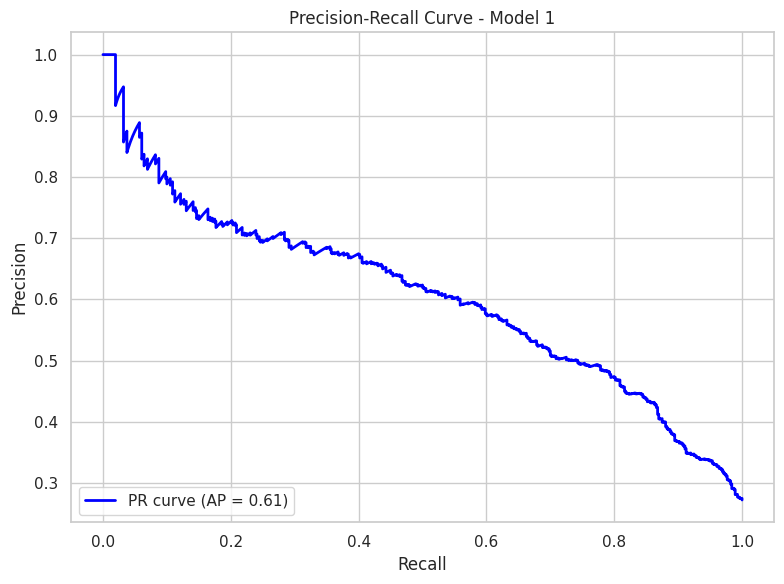

In [ ]:
# Re-create the validation set
_, val_df = train_test_split(
    annotations,
    test_size=0.2,
    random_state=42,
    stratify=annotations["hate_speech_binary"]
)
val_df = val_df.reset_index(drop=True)


val_df = val_df.rename(columns={"hate_speech_binary": "labels"})

tokenizer_model1 = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")

def tokenize_fn_model1(example):
    return tokenizer_model1(example["c_text"], truncation=True, padding="max_length", max_length=128)

# Convert val_df to a HuggingFace Dataset
val_dataset_model1 = Dataset.from_pandas(val_df)
val_dataset_model1 = val_dataset_model1.map(tokenize_fn_model1, batched=True)

cols_to_keep = ["input_ids", "attention_mask", "labels"]
val_dataset_model1 = val_dataset_model1.remove_columns(
    [col for col in val_dataset_model1.column_names if col not in cols_to_keep]
)

# Predict with raw logits
pred_output = trainer_model1.predict(val_dataset_model1)
logits = pred_output.predictions
y_true = pred_output.label_ids

# Convert logits to probabilities
probabilities = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
y_probs = probabilities[:, 1]

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 1")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Model 1")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

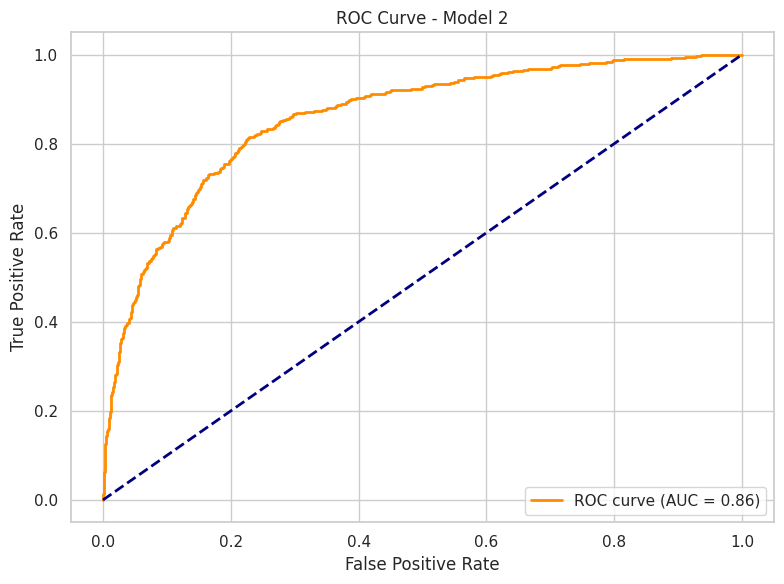

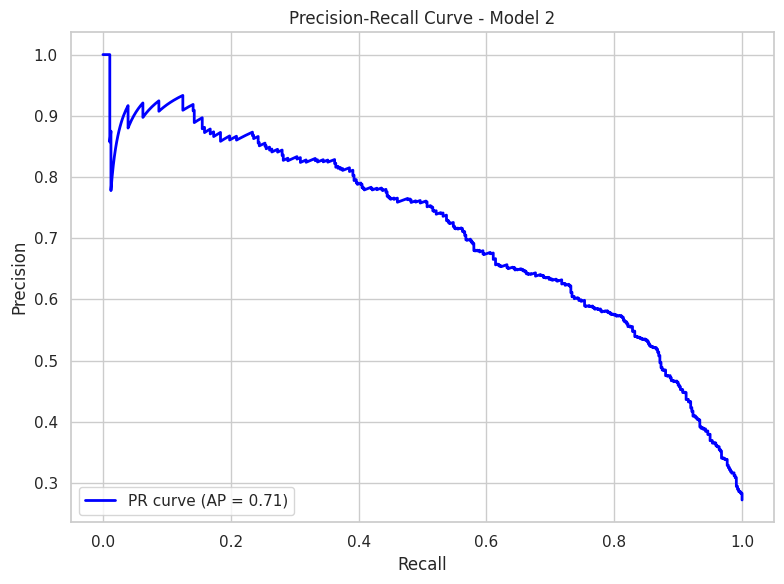

In [ ]:
# Re-create the validation set
_, val_df = train_test_split(
    annotations,
    test_size=0.2,
    random_state=42,
    stratify=annotations["hate_speech_binary"]
)
val_df = val_df.reset_index(drop=True)

val_df = val_df.rename(columns={"hate_speech_binary": "labels"})

tokenizer_model2 = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_fn_model2(example):
    return tokenizer_model2(example["c_text"], truncation=True, padding="max_length", max_length=128)

# Convert val_df to a HuggingFace Dataset
val_dataset_model2 = Dataset.from_pandas(val_df)
val_dataset_model2 = val_dataset_model2.map(tokenize_fn_model2, batched=True)

# Remove columns except 'input_ids', 'attention_mask', 'labels'
cols_to_keep = ["input_ids", "attention_mask", "labels"]
val_dataset_model2 = val_dataset_model2.remove_columns(
    [col for col in val_dataset_model2.column_names if col not in cols_to_keep]
)

# Predict with raw logits
pred_output = trainer_model2.predict(val_dataset_model2)
logits = pred_output.predictions
y_true = pred_output.label_ids

# Convert logits to probabilities
probabilities = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
y_probs = probabilities[:, 1]  # Probability for positive class

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 2")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Model 2")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [ ]:
# Define OUTPUT_DIR
OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"
_, val_df = train_test_split(annotations, test_size=0.2, random_state=42, stratify=annotations["hate_speech_binary"])

# For Transformer Model 1 predictions:
print("Aggregating Transformer Model 1 predictions...")

val_dataset_model1 = Dataset.from_pandas(val_df)

tokenizer_model1 = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")

def tokenize_fn_model1(example):
    return tokenizer_model1(example["c_text"], truncation=True)

# Map the tokenization function over the dataset.
tokenized_val_model1 = val_dataset_model1.map(tokenize_fn_model1, batched=True)
cols_to_keep = ["input_ids", "attention_mask", "labels"]
tokenized_val_model1 = tokenized_val_model1.remove_columns(
    [col for col in tokenized_val_model1.column_names if col not in cols_to_keep]
)

# Get predictions from trainer_model1.
preds_model1 = trainer_model1.predict(tokenized_val_model1).predictions.argmax(axis=-1)
val_df_model1 = val_df.copy()
val_df_model1["pred_trans1"] = preds_model1

# Save aggregated results to Drive.
aggregated_trans1_file = os.path.join(OUTPUT_DIR, "aggregated_trans1_results.csv")
val_df_model1.to_csv(aggregated_trans1_file, index=False)
print("Aggregated Transformer Model 1 results saved to", aggregated_trans1_file)

Aggregating Transformer Model 1 predictions...


Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Aggregated Transformer Model 1 results saved to /content/drive/MyDrive/NEW_TM_results/aggregated_trans1_results.csv


In [ ]:
# Define OUTPUT_DIR (must match your earlier setting)
OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"
_, val_df = train_test_split(annotations, test_size=0.2, random_state=42, stratify=annotations["hate_speech_binary"])

# For Transformer Model 1 predictions:
print("Aggregating Transformer Model 2 predictions...")
val_dataset_model2 = Dataset.from_pandas(val_df)
tokenizer_model2 = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_fn_model2(example):
    return tokenizer_model2(example["c_text"], truncation=True)

# Map the tokenization function over the dataset.
tokenized_val_model2 = val_dataset_model2.map(tokenize_fn_model2, batched=True)
cols_to_keep = ["input_ids", "attention_mask", "labels"]
tokenized_val_model2 = tokenized_val_model2.remove_columns(
    [col for col in tokenized_val_model2.column_names if col not in cols_to_keep]
)

# Get predictions from trainer_model1.
preds_model2 = trainer_model2.predict(tokenized_val_model2).predictions.argmax(axis=-1)
val_df_model2 = val_df.copy()
val_df_model2["pred_trans2"] = preds_model2

# Save aggregated results to Drive.
aggregated_trans2_file = os.path.join(OUTPUT_DIR, "aggregated_trans2_results.csv")
val_df_model2.to_csv(aggregated_trans2_file, index=False)
print("Aggregated Transformer Model 2 results saved to", aggregated_trans2_file)

Aggregating Transformer Model 2 predictions...


Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Aggregated Transformer Model 2 results saved to /content/drive/MyDrive/NEW_TM_results/aggregated_trans2_results.csv


In [ ]:
# Define your output directory (must match your previous setting)
OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"

# Re-create the validation set from annotations using the same split parameters.
_, val_df = train_test_split(annotations, test_size=0.2, random_state=42, stratify=annotations["hate_speech_binary"])
val_df = val_df.reset_index(drop=True)

# Initialize the tokenizer for Transformer Model 1.
tokenizer_model1 = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")

def tokenize_fn_model1(example):
    # Apply truncation and padding for uniform lengths.
    return tokenizer_model1(example["c_text"], truncation=True, padding="max_length", max_length=128)

val_dataset_model1 = Dataset.from_pandas(val_df)
val_dataset_model1 = val_dataset_model1.map(tokenize_fn_model1, batched=True)
cols_to_keep = ["input_ids", "attention_mask", "labels"]
val_dataset_model1 = val_dataset_model1.remove_columns(
    [col for col in val_dataset_model1.column_names if col not in cols_to_keep]
)

preds_model1 = trainer_model1.predict(val_dataset_model1).predictions.argmax(axis=-1)
val_df["pred_trans1"] = preds_model1

# Save the aggregated results to a CSV file.
aggregated_trans1_file = os.path.join(OUTPUT_DIR, "aggregated_trans1_results.csv")
val_df.to_csv(aggregated_trans1_file, index=False)
print("Aggregated Transformer Model 1 results saved to", aggregated_trans1_file)

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Aggregated Transformer Model 1 results saved to /content/drive/MyDrive/NEW_TM_results/aggregated_trans1_results.csv


In [ ]:
_, val_df2 = train_test_split(annotations, test_size=0.2, random_state=42, stratify=annotations["hate_speech_binary"])
val_df2 = val_df2.reset_index(drop=True)

# Initialize the tokenizer for Transformer Model 2.
tokenizer_model2 = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_fn_model2(example):
    return tokenizer_model2(example["c_text"], truncation=True, padding="max_length", max_length=128)

# Create a Dataset from the validation DataFrame.
val_dataset_model2 = Dataset.from_pandas(val_df2)
val_dataset_model2 = val_dataset_model2.map(tokenize_fn_model2, batched=True)
cols_to_keep = ["input_ids", "attention_mask", "labels"]
val_dataset_model2 = val_dataset_model2.remove_columns(
    [col for col in val_dataset_model2.column_names if col not in cols_to_keep]
)

# Obtain predictions from trainer_model2.
preds_model2 = trainer_model2.predict(val_dataset_model2).predictions.argmax(axis=-1)
val_df2["pred_trans2"] = preds_model2

# Save the aggregated results to a CSV file.
aggregated_trans2_file = os.path.join(OUTPUT_DIR, "aggregated_trans2_results.csv")
val_df2.to_csv(aggregated_trans2_file, index=False)
print("Aggregated Transformer Model 2 results saved to", aggregated_trans2_file)

Map:   0%|          | 0/2056 [00:00<?, ? examples/s]

Aggregated Transformer Model 2 results saved to /content/drive/MyDrive/NEW_TM_results/aggregated_trans2_results.csv


TF-IDF + XGBoost -- Accuracy: 0.7617, F1: 0.4053
ChatGPT -- Accuracy: 0.6752, F1: 0.5878
Transformer Model 1 -- Accuracy: 0.7904, F1: 0.5651
Transformer Model 2 -- Accuracy: 0.8161, F1: 0.6309
Aggregated evaluation metrics saved to /content/drive/MyDrive/NEW_TM_results/aggregated_model_results.csv
Aggregated Model Evaluation Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score
0     TF-IDF + XGBoost  0.761673   0.632576  0.298214  0.405340
1              ChatGPT  0.675224   0.448822  0.851269  0.587756
2  Transformer Model 1  0.790370   0.649652  0.500000  0.565086
3  Transformer Model 2  0.816148   0.696121  0.576786  0.630859
Merged Predictions for Error Analysis:
                                              c_text  hate_speech_binary  \
0  !!! ACHTUNG: Verstörender Inhalt !!!\nUns erre...                   0   
1  "...Orden der einsamen Gerechten." \n\nWenn ih...                   0   
2  "...und dann kommen die aus ihren kleinen, dun...                   0   
3

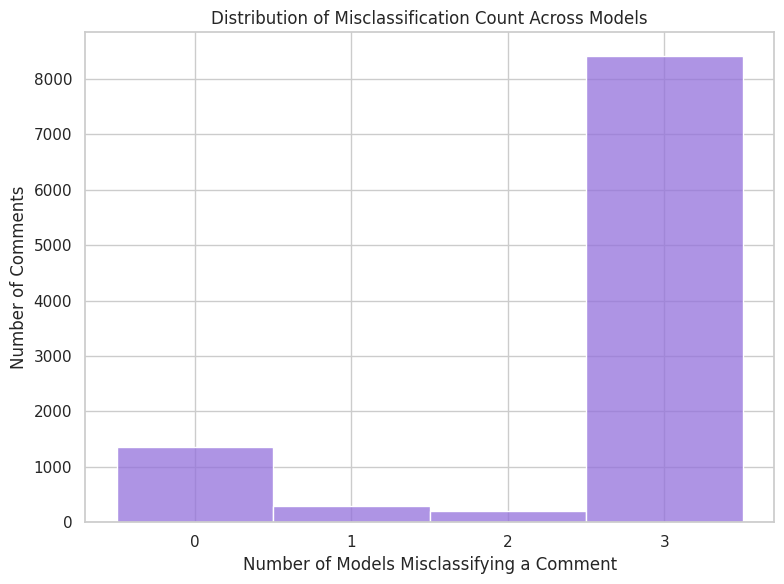

Error Summary Table (Across Models):
   Num_Misclassifications  Count
0                       0   1363
1                       1    294
2                       2    210
3                       3   8417

Comments misclassified by all models (first 10):
                                               c_text  hate_speech_binary  \
1   "...Orden der einsamen Gerechten." \n\nWenn ih...                   0   
2   "...und dann kommen die aus ihren kleinen, dun...                   0   
3   "Angebot" geklaut von Fr. Baerbock? Oder von F...                   0   
4   "Bei den Geldern handelt es sich demnach um So...                   0   
5                          "Bitch" is gender neutral.                   1   
6   "Braucht man da Eierstöcke?" - Baerbock im ers...                   0   
7   "Der Roman ist ja immer noch da...".🙄 "Oh, gut...                   0   
8   "Deshalb ist die Befreiung Palästinas für jede...                   0   
10  "Diese Entwicklung in Deutschland ist nicht nu...  

In [ ]:
# Define file paths for each model's results.
OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"
tfidf_file = os.path.join(OUTPUT_DIR, "aggregated_tfidf_results.csv")
chatgpt_file = os.path.join(OUTPUT_DIR, "chatgpt_results.csv")
trans1_file = os.path.join(OUTPUT_DIR, "aggregated_trans1_results.csv")
trans2_file = os.path.join(OUTPUT_DIR, "aggregated_trans2_results.csv")

# Load results if they exist.
results = {}
if os.path.exists(tfidf_file):
    results["TF-IDF + XGBoost"] = pd.read_csv(tfidf_file)
else:
    print("TF-IDF results file not found.")
if os.path.exists(chatgpt_file):
    results["ChatGPT"] = pd.read_csv(chatgpt_file)
else:
    print("ChatGPT results file not found.")
if os.path.exists(trans1_file):
    results["Transformer Model 1"] = pd.read_csv(trans1_file)
else:
    print("Transformer Model 1 results file not found.")
if os.path.exists(trans2_file):
    results["Transformer Model 2"] = pd.read_csv(trans2_file)
else:
    print("Transformer Model 2 results file not found.")

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
eval_metrics = {}
for model_name, df in results.items():
    if "hate_speech_binary" in df.columns:
        true_labels = df["hate_speech_binary"]
        if model_name == "TF-IDF + XGBoost":
            pred_labels = df.get("pred_tfidf", None)
        elif model_name == "ChatGPT":
            if "chatgpt_pred" in df.columns:
                pred_labels = df["chatgpt_pred"]
            else:
                pred_labels = pd.to_numeric(df.get("chatgpt_class", None), errors="coerce")
        elif model_name == "Transformer Model 1":
            pred_labels = df.get("pred_trans1", None)
        elif model_name == "Transformer Model 2":
            pred_labels = df.get("pred_trans2", None)
        else:
            pred_labels = None
        if pred_labels is not None:
            valid_idx = pred_labels.notnull()
            if valid_idx.sum() == 0:
                print(f"No valid predictions for {model_name}.")
                continue
            valid_true = true_labels[valid_idx]
            valid_pred = pred_labels[valid_idx]
            acc = accuracy_score(valid_true, valid_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(valid_true, valid_pred, average="binary")
            eval_metrics[model_name] = {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1 Score": f1}
            print(f"{model_name} -- Accuracy: {acc:.4f}, F1: {f1:.4f}")
        else:
            print(f"Predictions not found for {model_name}.")

# Aggregate evaluation metrics into a DataFrame.
def aggregate_model_results(results_list, model_names, save_path=None):
    comparison_data = {
        "Model": model_names,
        "Accuracy": [res.get("Accuracy", None) for res in results_list],
        "Precision": [res.get("Precision", None) for res in results_list],
        "Recall": [res.get("Recall", None) for res in results_list],
        "F1 Score": [res.get("F1 Score", None) for res in results_list]
    }
    agg_df = pd.DataFrame(comparison_data)
    if save_path:
        agg_df.to_csv(save_path, index=False)
        print("Aggregated evaluation metrics saved to", save_path)
    return agg_df

model_names_list = list(eval_metrics.keys())
results_list = [eval_metrics[name] for name in model_names_list]
agg_file = os.path.join(OUTPUT_DIR, "aggregated_model_results.csv")
agg_df = aggregate_model_results(results_list, model_names_list, save_path=agg_file)
print("Aggregated Model Evaluation Metrics:")
print(agg_df)

# For cross-model error analysis, merge predictions from all models on a unique identifier (here, 'c_text').
from functools import reduce
dfs = []
for model_name, df in results.items():
    pred_col = None
    if model_name == "TF-IDF + XGBoost":
        pred_col = "pred_tfidf"
    elif model_name == "ChatGPT":
        if "chatgpt_pred" in df.columns:
            pred_col = "chatgpt_pred"
        elif "chatgpt_class" in df.columns:
            pred_col = "chatgpt_class"
    elif model_name == "Transformer Model 1":
        pred_col = "pred_trans1"
    elif model_name == "Transformer Model 2":
        pred_col = "pred_trans2"
    if pred_col:
        required_cols = ["c_text", "hate_speech_binary", pred_col]
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            print(f"Skipping {model_name} for error analysis because columns {missing} are missing.")
        else:
            dfs.append(df[required_cols])
if len(dfs) == 0:
    print("No model files have the required columns for error analysis.")
else:
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=["c_text", "hate_speech_binary"], how="outer"), dfs)
    print("Merged Predictions for Error Analysis:")
    print(merged_df.head())

    merged_df = perform_error_analysis(merged_df, model_pred_cols=[col for col in merged_df.columns if col.startswith("pred_")], true_col="hate_speech_binary")
    final_aggregated_file = os.path.join(OUTPUT_DIR, "final_aggregated_model_results.csv")
    merged_df.to_csv(final_aggregated_file, index=False)
    print("Final aggregated model results saved to", final_aggregated_file)

In [ ]:
final_res = pd.read_csv('/content/drive/MyDrive/NEW_TM_results/final_aggregated_model_results.csv', header=0)
final_res.head()

,c_text,hate_speech_binary,pred_tfidf,chatgpt_class,pred_trans1,pred_trans2,error_count
0,!!! ACHTUNG: Verstörender Inhalt !!!\nUns erre...,0,0.0,1.0,0.0,0.0,0
1,"""...Orden der einsamen Gerechten."" \n\nWenn ih...",0,NaN,1.0,NaN,NaN,3
2,"""...und dann kommen die aus ihren kleinen, dun...",0,NaN,1.0,NaN,NaN,3
3,"""Angebot"" geklaut von Fr. Baerbock? Oder von F...",0,NaN,0.0,NaN,NaN,3
4,"""Bei den Geldern handelt es sich demnach um So...",0,NaN,0.0,NaN,NaN,3


In [ ]:
import os
import pandas as pd
from functools import reduce

OUTPUT_DIR = "/content/drive/MyDrive/NEW_TM_results/"
tfidf_file   = os.path.join(OUTPUT_DIR, "aggregated_tfidf_results.csv")
chatgpt_file = os.path.join(OUTPUT_DIR, "chatgpt_results.csv")
trans1_file  = os.path.join(OUTPUT_DIR, "aggregated_trans1_results.csv")
trans2_file  = os.path.join(OUTPUT_DIR, "aggregated_trans2_results.csv")

aggregator_dfs = {}
if os.path.exists(tfidf_file):
    aggregator_dfs["TF-IDF + XGBoost"] = pd.read_csv(tfidf_file)
else:
    print("TF-IDF file not found.")

if os.path.exists(chatgpt_file):
    aggregator_dfs["ChatGPT"] = pd.read_csv(chatgpt_file)
else:
    print("ChatGPT file not found.")

if os.path.exists(trans1_file):
    aggregator_dfs["Transformer Model 1"] = pd.read_csv(trans1_file)
else:
    print("Transformer Model 1 file not found.")

if os.path.exists(trans2_file):
    aggregator_dfs["Transformer Model 2"] = pd.read_csv(trans2_file)
else:
    print("Transformer Model 2 file not found.")

model_pred_map = {
    "TF-IDF + XGBoost": "pred_tfidf",
    "ChatGPT": None,  # We'll detect chatgpt_pred or chatgpt_class
    "Transformer Model 1": "pred_trans1",
    "Transformer Model 2": "pred_trans2"
}

dfs_for_merge = []
for model_name, df in aggregator_dfs.items():
    pred_col = model_pred_map.get(model_name)
    if model_name == "ChatGPT":
        if "chatgpt_pred" in df.columns:
            pred_col = "chatgpt_pred"
        elif "chatgpt_class" in df.columns:
            pred_col = "chatgpt_class"
        else:
            print(f"No ChatGPT prediction column found in {model_name} aggregator file. Skipping.")
            continue

    required_cols = ["c_text", "hate_speech_binary", pred_col]
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        print(f"Skipping {model_name} because columns {missing} are missing.")
        continue

    df_sub = df[required_cols].copy()
    if model_name == "ChatGPT" and pred_col == "chatgpt_class":
        df_sub.rename(columns={"chatgpt_class": "pred_chatgpt"}, inplace=True)
        pred_col = "pred_chatgpt"
    elif model_name == "ChatGPT" and pred_col == "chatgpt_pred":
        df_sub.rename(columns={"chatgpt_pred": "pred_chatgpt"}, inplace=True)
        pred_col = "pred_chatgpt"

    dfs_for_merge.append(df_sub)

# Merge all aggregator DataFrames on ['c_text', 'hate_speech_binary'] using an *inner* join
if len(dfs_for_merge) == 0:
    print("No aggregator DataFrames to merge.")
else:
    final_res = dfs_for_merge[0]
    for next_df in dfs_for_merge[1:]:
        final_res = pd.merge(final_res, next_df, on=["c_text", "hate_speech_binary"], how="inner")

    print(f"After merging aggregator files (inner join), final_res has {len(final_res)} rows.")
    print(final_res.head())
    final_res = pd.merge(final_res, annotations, on="c_text", how="inner", suffixes=("", "_ann"))
    print(f"After merging with annotations, final_res has {len(final_res)} rows and columns {list(final_res.columns)}")
    final_aggregated_file = os.path.join(OUTPUT_DIR, "final_res_aggregated.csv")
    final_res.to_csv(final_aggregated_file, index=False)
    print("Saved final_res to", final_aggregated_file)

After merging aggregator files (inner join), final_res has 2062 rows.
                                              c_text  hate_speech_binary  \
0  Wir werden nie erfahren, warum nun plötzlich d...                   0   
1  @Eddy_Bernayz @AliCologne Weil Spahn immer ges...                   0   
2  @JrgSchwarz6 Überschrift\nKlingbeil"Scheibenkl...                   0   
3  @PeterBe38098838 @reitschuster 🤦‍♀️ am Tag der...                   0   
4  @Karl_Lauterbach Bin ich der einzige der die t...                   0   

   pred_tfidf  pred_chatgpt  pred_trans1  pred_trans2  
0           0           0.0            0            0  
1           1           0.0            0            0  
2           0           1.0            1            0  
3           0           1.0            0            0  
4           0           0.0            0            0  
After merging with annotations, final_res has 2070 rows and columns ['c_text', 'hate_speech_binary', 'pred_tfidf', 'pred_chatgpt', 'pred_

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/NEW_TM_results/final_res_aggregated.csv')

In [ ]:
final.head()

,c_text,hate_speech_binary,pred_tfidf,pred_chatgpt,pred_trans1,pred_trans2,c_id,nb_annotators,dataset_id,duration,...,discrim_engagement,discrim_sexIdent,discrim_characteristics,discrim_nation,discrim_religion,discrim_socialStatus,discrim_worldview,discrim_Ethnicity,threat,extrem
0,"Wir werden nie erfahren, warum nun plötzlich d...",0,0,0.0,0,0,1388615446371479554,4,5.0,114.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,@Eddy_Bernayz @AliCologne Weil Spahn immer ges...,0,1,0.0,0,0,1385154810043830272,3,3.0,36.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"@JrgSchwarz6 Überschrift\nKlingbeil""Scheibenkl...",0,0,1.0,1,0,1391676551952011265,3,8.0,51.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,@PeterBe38098838 @reitschuster 🤦‍♀️ am Tag der...,0,0,1.0,0,0,1390993417216401410,3,5.0,61.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,@Karl_Lauterbach Bin ich der einzige der die t...,0,0,0.0,0,0,1386336754551111682,3,3.0,31.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final.columns

Index(['c_text', 'hate_speech_binary', 'pred_tfidf', 'pred_chatgpt',
       'pred_trans1', 'pred_trans2', 'c_id', 'nb_annotators', 'dataset_id',
       'duration', 'incomp', 'sentiment', 'hate_speech', 'criminal_rel',
       'p_86', 'p_86a', 'p_111', 'p_126', 'p_130', 'p_131', 'p_140', 'p_166',
       'p_185', 'p_186', 'p_187', 'p_189', 'p_240', 'p_241',
       'expression_explicit', 'expression_implicit', 'toxi', 'target_person',
       'target_group', 'target_public', 'discrim_job', 'discrim_attitude',
       'discrim_engagement', 'discrim_sexIdent', 'discrim_characteristics',
       'discrim_nation', 'discrim_religion', 'discrim_socialStatus',
       'discrim_worldview', 'discrim_Ethnicity', 'threat', 'extrem'],
      dtype='object')

In [ ]:
def show_all_misclassified(
    df,
    model_pred_cols=["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"],
    true_col="hate_speech_binary",
    max_examples=10
):
    """
    Identify rows misclassified by *all* models and display them in full length.

    :param df: The final DataFrame containing ground truth and model predictions.
    :param model_pred_cols: A list of columns for each model's predictions.
    :param true_col: The name of the ground truth label column.
    :param max_examples: How many examples to show.
    :return: A DataFrame containing only the rows misclassified by all models.
    """

    # Create an 'error' column for each model: True if model != ground truth
    for col in model_pred_cols:
        df[f"err_{col}"] = df[col] != df[true_col]

    # Sum up how many models misclassify each row
    error_cols = [f"err_{col}" for col in model_pred_cols]
    df["error_count"] = df[error_cols].sum(axis=1)

    # Filter rows where error_count == number_of_models
    all_wrong = df[df["error_count"] == len(model_pred_cols)]
    print(f"Number of rows misclassified by all {len(model_pred_cols)} models: {len(all_wrong)}")

    # Show first few examples with full text
    display_cols = [true_col] + model_pred_cols + ["c_text"]

    # Temporarily set display options to avoid truncation
    with pd.option_context('display.max_colwidth', None):
        print(f"\nShowing first {max_examples} examples misclassified by all models:")
        print(all_wrong[display_cols].head(max_examples).to_string(index=False))

    return all_wrong



In [ ]:
all_misclassified = show_all_misclassified(final)

Number of rows misclassified by all 4 models: 70

Showing first 10 examples misclassified by all models:
 hate_speech_binary  pred_tfidf  pred_chatgpt  pred_trans1  pred_trans2                                                                                                                                                                                                                                                                                                                                 c_text
                  1           0           0.0            0            0 @Schmitz441 @Andrea_Stoll_ @PhilHackemann @ABaerbock diese diskussion hat vielmehr mit der armseligkeit derer zu tun, die sie angezettelt haben. vielleicht ist die diskussion ja auch ein ablenkungsmanöver von maskendeals, charaktermängeln von Kanzlerkandidaten und rechtsextremen ex-verfassungsschützern in den eigenen reihen.
                  1           0           0.0            0            0                          


Bar chart showing misclassification counts:
error_count
0    982
1    555
2    261
3    202
4     70
Name: count, dtype: int64 

Sum of error counts is 1088


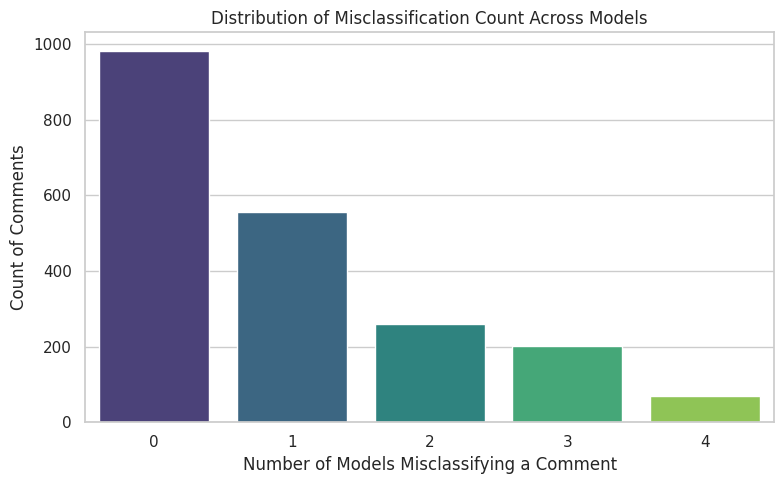

In [ ]:
def visualize_misclassification_distribution(
    df,
    model_pred_cols=["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"],
    true_col="hate_speech_binary"
):
    """
    Visualize how many comments are misclassified by 0, 1, 2, ... models.

    Steps:
      1. Create error columns (err_<model>) for each model, indicating misclassification (True/False).
      2. Sum them into 'error_count'.
      3. Plot a bar chart showing how many rows have error_count == 0, 1, 2, etc.

    :param df: DataFrame with ground truth + model prediction columns.
    :param model_pred_cols: List of model prediction columns.
    :param true_col: The ground truth label column.
    :return: None (displays a bar chart).
    """
    # Create error columns if not already present
    for col in model_pred_cols:
        err_col = f"err_{col}"
        if err_col not in df.columns:
            df[err_col] = (df[col] != df[true_col])

    # Sum them into 'error_count'
    error_cols = [f"err_{col}" for col in model_pred_cols]
    df["error_count"] = df[error_cols].sum(axis=1)

    # Plot a bar chart
    counts = df["error_count"].value_counts().sort_index()
    print("\nBar chart showing misclassification counts:")
    print(counts, f"\n\nSum of error counts is 1088")
    plt.figure(figsize=(8,5))
    sns.barplot(x=counts.index.astype(int), y=counts.values, palette="viridis")
    plt.title("Distribution of Misclassification Count Across Models")
    plt.xlabel("Number of Models Misclassifying a Comment")
    plt.ylabel("Count of Comments")
    plt.xticks(counts.index.astype(int))
    plt.tight_layout()
    plt.show()

visualize_misclassification_distribution(final)


Average misclassification rate by is_explicit:
   is_explicit  err_pred_tfidf  err_pred_chatgpt  err_pred_trans1  \
0        False        0.208333          0.333333         0.083333   
1         True        0.237738          0.320320         0.212713   

   err_pred_trans2  
0         0.138889  
1         0.184184  

Average misclassification rate by is_implicit:
   is_implicit  err_pred_tfidf  err_pred_chatgpt  err_pred_trans1  \
0        False        0.223375          0.280775         0.198479   
1         True        0.267628          0.413462         0.230769   

   err_pred_trans2  
0         0.168050  
1         0.216346  


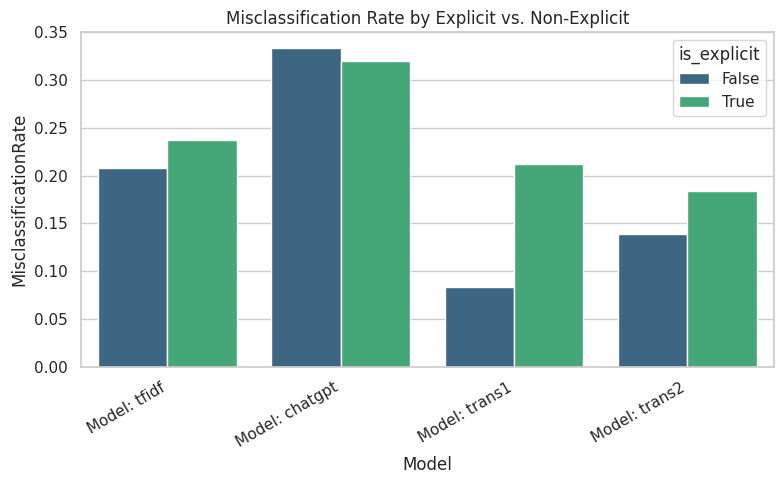

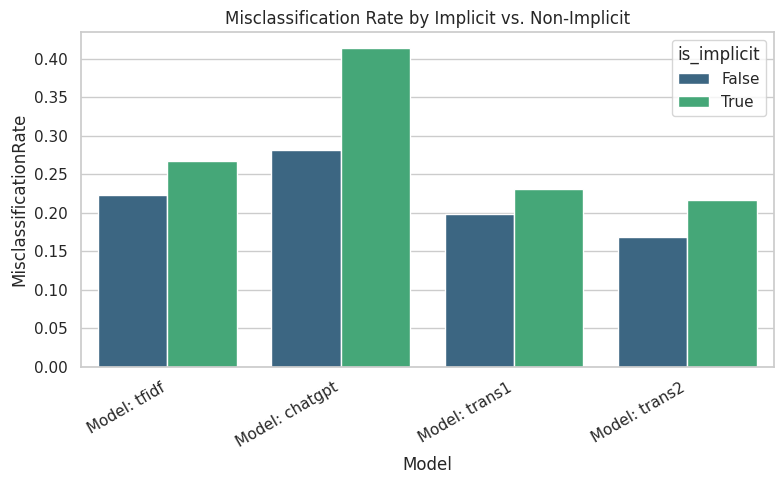


Plots displayed: bar charts of misclassification rates by explicit/implicit.



In [ ]:
def analyze_explicit_implicit_misclassification(
    df,
    model_pred_cols=["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"],
    true_col="hate_speech_binary",
    explicit_col="expression_explicit",
    implicit_col="expression_implicit",
    threshold=0
):
    """
    Analyze how explicit/implicit columns relate to misclassification.

    Steps:
      1. Define binary columns: is_explicit = (expression_explicit > threshold),
         is_implicit = (expression_implicit > threshold).
      2. Create or reuse error columns for each model: err_<model_col>.
      3. Group by is_explicit/is_implicit and compute average misclassification rate.
      4. Plot bar charts to compare error rates across groups.

    :param df: The final merged DataFrame (with predictions + annotation columns).
    :param model_pred_cols: List of model prediction columns.
    :param true_col: Ground truth label column (e.g. "hate_speech_binary").
    :param explicit_col: Name of the explicit expression column (e.g. "expression_explicit").
    :param implicit_col: Name of the implicit expression column (e.g. "expression_implicit").
    :param threshold: Numeric threshold to treat expression_explicit / expression_implicit as True if > threshold.
    :return: None (prints results and shows plots).
    """

    # Define binary columns
    df["is_explicit"] = df[explicit_col] > threshold
    df["is_implicit"] = df[implicit_col] > threshold

    # Create error columns if not already present
    for col in model_pred_cols:
        err_col = f"err_{col}"
        if err_col not in df.columns:
            df[err_col] = (df[col] != df[true_col])

    # Group by is_explicit/is_implicit and compute average misclassification
    error_cols = [f"err_{col}" for col in model_pred_cols]

    # For explicit
    group_explicit = df.groupby("is_explicit")[error_cols].mean().reset_index()
    print("Average misclassification rate by is_explicit:")
    print(group_explicit)

    # For implicit
    group_implicit = df.groupby("is_implicit")[error_cols].mean().reset_index()
    print("\nAverage misclassification rate by is_implicit:")
    print(group_implicit)

    # Melt the group_explicit for plotting
    group_explicit_melt = group_explicit.melt(id_vars="is_explicit", value_vars=error_cols,
                                             var_name="Model", value_name="MisclassificationRate")
    # Convert "err_pred_tfidf" -> "TF-IDF + XGBoost" etc. if desired
    group_explicit_melt["Model"] = group_explicit_melt["Model"].str.replace("err_pred_", "Model: ")

    plt.figure(figsize=(8, 5))
    sns.barplot(data=group_explicit_melt, x="Model", y="MisclassificationRate", hue="is_explicit", palette="viridis")
    plt.title("Misclassification Rate by Explicit vs. Non-Explicit")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="is_explicit")
    plt.tight_layout()
    plt.show()

    # Melt the group_implicit for plotting
    group_implicit_melt = group_implicit.melt(id_vars="is_implicit", value_vars=error_cols,
                                              var_name="Model", value_name="MisclassificationRate")
    group_implicit_melt["Model"] = group_implicit_melt["Model"].str.replace("err_pred_", "Model: ")

    plt.figure(figsize=(8, 5))
    sns.barplot(data=group_implicit_melt, x="Model", y="MisclassificationRate", hue="is_implicit", palette="viridis")
    plt.title("Misclassification Rate by Implicit vs. Non-Implicit")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="is_implicit")
    plt.tight_layout()
    plt.show()

    print("\nPlots displayed: bar charts of misclassification rates by explicit/implicit.\n")


model_pred_cols = ["pred_tfidf", "pred_chatgpt", "pred_trans1", "pred_trans2"]
analyze_explicit_implicit_misclassification(final, model_pred_cols=model_pred_cols)

In [ ]:
both_mask = (final["expression_explicit"] > 0) & (final["expression_implicit"] > 0)

both_count = both_mask.sum()
print("Number of comments flagged as both explicit and implicit:", both_count)

# Optionally, show the first few examples
both_df = final[both_mask]
print("\nExample rows flagged as both:")
print(both_df[["c_text", "expression_explicit", "expression_implicit"]].head(10).to_string(index=False))


Number of comments flagged as both explicit and implicit: 573

Example rows flagged as both:
                                                                                                                                                                                                                                                                                                                                c_text  expression_explicit  expression_implicit
                                                                   @JrgSchwarz6 Überschrift\nKlingbeil"Scheibenkleister ich beleidige ja nur"\nMützenich "Was tu ich hier eigentlich"\nWalter-Borjans "Hol mir mal ne Flasche Bier"\nEsken " Wo ist mein Antifa Bild den hin?"\nAlle im schönen schwarz passt zur Stimmung für die SPD                    1                    1
                                                                                                                                                       @PeterBe38098838 @


Average misclassification rate by is_person:
   is_person  err_pred_tfidf  err_pred_chatgpt  err_pred_trans1  \
0      False        0.290486          0.278340         0.247976   
1       True        0.187616          0.359519         0.171904   

   err_pred_trans2  
0         0.213563  
1         0.154344  


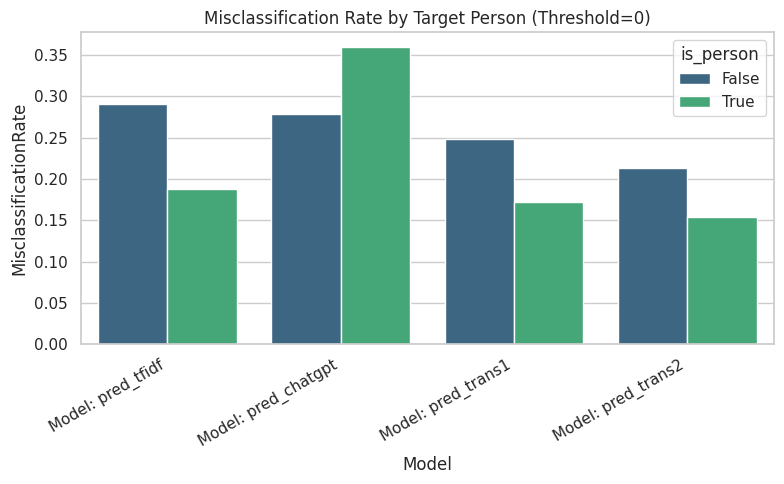


Average misclassification rate by is_group:
   is_group  err_pred_tfidf  err_pred_chatgpt  err_pred_trans1  \
0     False        0.108230          0.307779         0.102593   
1      True        0.333052          0.330516         0.287405   

   err_pred_trans2  
0         0.087937  
1         0.253593  


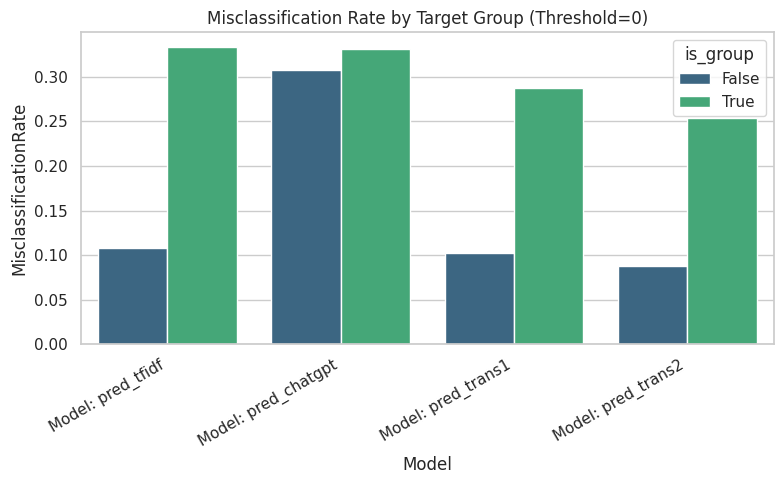


Average misclassification rate by is_public:
   is_public  err_pred_tfidf  err_pred_chatgpt  err_pred_trans1  \
0      False        0.299114          0.349335         0.250369   
1       True        0.118715          0.266760         0.128492   

   err_pred_trans2  
0         0.225997  
1         0.100559  


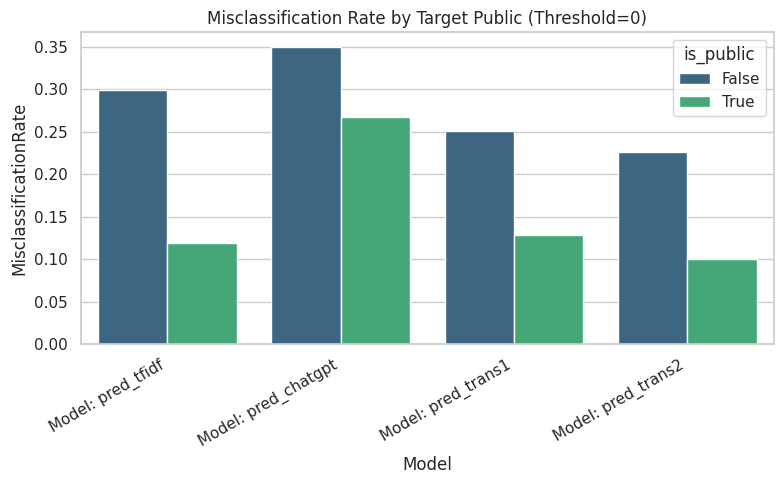


Done. Displayed bar charts for misclassification rates vs. Person/Group/Public.


In [ ]:
def analyze_target_misclassification(
    df,
    model_pred_cols=["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"],
    true_col="hate_speech_binary",
    person_col="target_person",
    group_col="target_group",
    public_col="target_public",
    threshold=0
):
    """
    Analyze how misclassification rates differ for comments targeting a person, group, or public.

    Steps:
      1. Define is_person = (df[person_col] > threshold), similarly is_group, is_public.
      2. Create or reuse error columns (err_<model>) for each model.
      3. Group by is_person/is_group/is_public and compute average misclassification rate.
      4. Plot bar charts comparing misclassification rates for each model across True vs. False.

    :param df: The final merged DataFrame (with predictions + annotation columns).
    :param model_pred_cols: List of model prediction columns.
    :param true_col: Ground truth label column (e.g. "hate_speech_binary").
    :param person_col: Name of the column for person-target info (e.g. "target_person").
    :param group_col: Name of the column for group-target info (e.g. "target_group").
    :param public_col: Name of the column for public-target info (e.g. "target_public").
    :param threshold: Numeric threshold to treat > threshold as True (e.g. 0 means any annotator).
    :return: None (prints and shows plots).
    """

    # Define binary columns
    df["is_person"] = df[person_col] > threshold
    df["is_group"]  = df[group_col]  > threshold
    df["is_public"] = df[public_col] > threshold

    # Create error columns if not already present
    for col in model_pred_cols:
        err_col = f"err_{col}"
        if err_col not in df.columns:
            df[err_col] = (df[col] != df[true_col])

    error_cols = [f"err_{col}" for col in model_pred_cols]

    # Helper function to group, print, and plot bar chart
    def group_and_plot(df, group_col_name, title_suffix):
        group_data = df.groupby(group_col_name)[error_cols].mean().reset_index()
        print(f"\nAverage misclassification rate by {group_col_name}:")
        print(group_data)

        # Melt for plotting
        melted = group_data.melt(id_vars=group_col_name, value_vars=error_cols,
                                 var_name="Model", value_name="MisclassificationRate")
        melted["Model"] = melted["Model"].str.replace("err_", "Model: ")

        plt.figure(figsize=(8, 5))
        sns.barplot(data=melted, x="Model", y="MisclassificationRate", hue=group_col_name, palette="viridis")
        plt.title(f"Misclassification Rate by {title_suffix} (Threshold={threshold})")
        plt.xticks(rotation=30, ha="right")
        plt.legend(title=group_col_name)
        plt.tight_layout()
        plt.show()

    # Group by is_person
    group_and_plot(df, "is_person", "Target Person")

    # Group by is_group
    group_and_plot(df, "is_group", "Target Group")

    # Group by is_public
    group_and_plot(df, "is_public", "Target Public")

    print("\nDone. Displayed bar charts for misclassification rates vs. Person/Group/Public.")

model_pred_cols = ["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"]
analyze_target_misclassification(final, model_pred_cols=model_pred_cols)

Difference in misclassification rates (True - False) for each discrimination type:

                         pred_tfidf  pred_chatgpt  pred_trans1  pred_trans2
discrim_job                   0.414        -0.143        0.285        0.088
discrim_attitude              0.515        -0.177        0.315        0.261
discrim_engagement            0.447        -0.168        0.142        0.196
discrim_sexIdent              0.691        -0.245        0.255        0.358
discrim_characteristics       0.426        -0.167        0.169        0.227
discrim_nation                0.552        -0.161        0.372        0.356
discrim_religion              0.730        -0.240        0.253        0.321
discrim_socialStatus          0.365        -0.222        0.092        0.017
discrim_worldview             0.431        -0.088        0.331        0.228
discrim_Ethnicity             0.561        -0.325        0.380        0.237


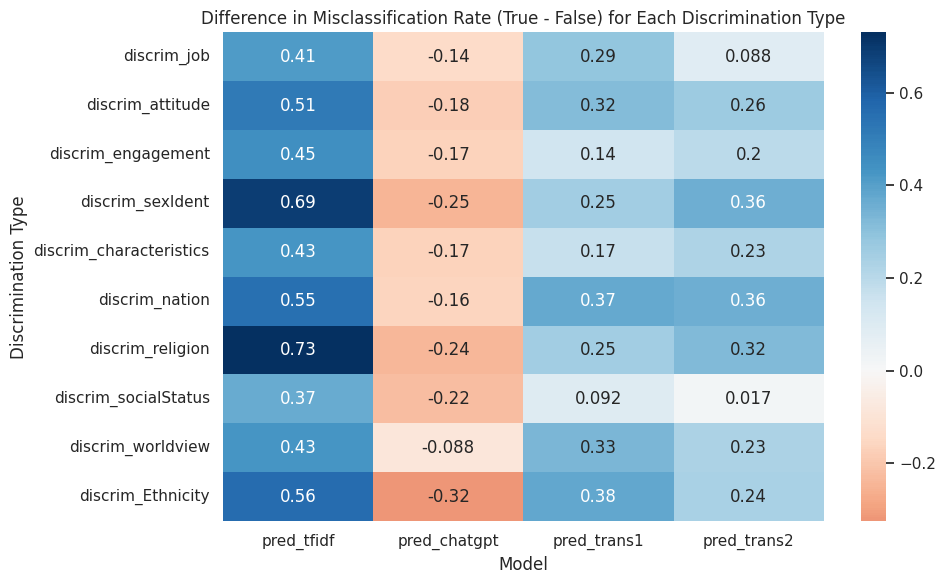

In [ ]:
def analyze_discrimination_types(
    df,
    discrim_cols=None,
    model_pred_cols=["pred_tfidf","pred_chatgpt","pred_trans1","pred_trans2"],
    true_col="hate_speech_binary",
    threshold=0.0
):
    """
    Analyzes how each discrimination type (discrim_xxx) correlates with misclassification.
    Creates a table + heatmap showing the difference in error rates (True - False) for each type.

    Steps:
      1. Ensure error columns exist for each model (err_<model_pred>).
      2. For each discrimination column (discrim_xxx):
         - Define a binary indicator is_discrim = (df[col] > threshold).
         - Group by is_discrim and compute mean error rate for each model.
         - Compute the difference in misclassification rate: rate(True) - rate(False).
      3. Store the differences in a DataFrame, one row per discrim_xxx, columns for each model.
      4. Print the table of differences, then plot a heatmap.

    :param df: The final merged DataFrame with predictions + annotation columns.
    :param discrim_cols: List of discrimination columns (e.g. ['discrim_attitude','discrim_nation',...]).
                         If None, we'll detect columns that start with "discrim_".
    :param model_pred_cols: Columns for each model's predictions.
    :param true_col: Ground truth label column (e.g. "hate_speech_binary").
    :param threshold: Numeric threshold to treat discrim_xxx as True if > threshold.
    :return: A DataFrame (diff_df) containing the difference in error rates for each discrimination type and model.
    """

    # If no discrim_cols specified, detect columns starting with 'discrim_'
    if discrim_cols is None:
        discrim_cols = [c for c in df.columns if c.startswith("discrim_")]
    for col in model_pred_cols:
        err_col = f"err_{col}"
        if err_col not in df.columns:
            df[err_col] = (df[col] != df[true_col])

    # DataFrame that has one row per discrimination col, columns for each model's difference
    error_cols = [f"err_{col}" for col in model_pred_cols]
    diff_df = pd.DataFrame(index=discrim_cols, columns=error_cols, dtype=float)

    # For each discrim column, define is_discrim and compute difference in error rates
    for col in discrim_cols:
        is_discrim = (df[col] > threshold)
        # Group by is_discrim, compute mean of error columns
        group_means = df.groupby(is_discrim)[error_cols].mean()
        # If True or False missing (e.g. no True rows?), skip
        if True not in group_means.index or False not in group_means.index:
            continue

        # difference = mean error rate for True - mean error rate for False
        diff = group_means.loc[True] - group_means.loc[False]
        diff_df.loc[col, :] = diff.values

    # diff_df now has rows for each discrimination col, columns for each model's error col
    rename_map = {}
    for err_col in error_cols:
        rename_map[err_col] = err_col.replace("err_", "")

    diff_df.rename(columns=rename_map, inplace=True)

    # Print the table of differences
    print("Difference in misclassification rates (True - False) for each discrimination type:\n")
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        print(diff_df.round(3).to_string())

    # Plot a heatmap of those differences
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, max(6, len(diff_df.index)*0.5)))
    sns.heatmap(diff_df.astype(float), annot=True, cmap="RdBu", center=0)
    plt.title("Difference in Misclassification Rate (True - False) for Each Discrimination Type")
    plt.xlabel("Model")
    plt.ylabel("Discrimination Type")
    plt.tight_layout()
    plt.show()

    return diff_df

diff_df = analyze_discrimination_types(final)
